**Before you start**

- Make a copy of notebook (1)
- Connect to the runtime (2)

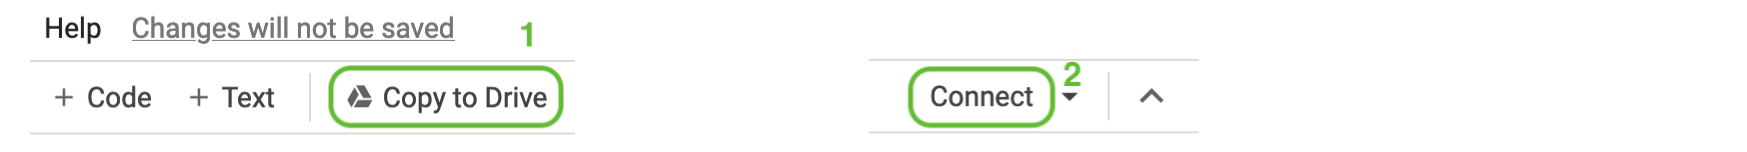


# **AI Lab: Snapshot Hyperspectral Imaging**
*Jakob Schröder, Sunny Howard & Andreas Döpp*





```
# Als Code formatiert
```

---
# 1. Introduction
---

> Hyperspectral imaging (HSI) is a powerful technique that captures both spatial and spectral information of a scene. While traditional RGB cameras only acquire three color channels, HSI systems sample the visible spectrum at many narrow wavelength bands, providing a high-resolution spectral signature at each pixel location. This rich spatio-spectral data enables a wide range of applications, from material identification and classification to color analysis and visualization.

<div align="center">
    <img src="https://www.researchgate.net/publication/221667446/figure/fig1/AS:669033993097225@1536521542313/Hyperspectral-imaging-concept.jpg" width="400"/>
</div>


Conventional HSI systems often rely on scanning techniques, such as pushbroom or whiskbroom scanners, to sequentially capture spectral information one pixel (or line of pixels) at a time. Although these methods can provide high-quality hyperspectral data, they require expensive and complex hardware, limiting their accessibility and flexibility. Moreover, the sequential scanning process is inherently time-consuming, making it challenging to capture dynamic scenes or minimize the effects of noise and motion.

<div align="center">
    <img src="https://www.researchgate.net/publication/343764008/figure/fig2/AS:932482404872194@1599332538136/Overview-of-common-HSI-techniques-3-different-HSI-set-ups-are-commonly-used-Push-broom.jpg" width="400"/>
</div>


> Snapshot hyperspectral imaging offers an attractive alternative by capturing the entire 3D spatio-spectral "hypercube" in a single shot using a 2D detector array. This significantly reduces the acquisition time, enabling the capture of dynamic scenes and minimizing the influence of noise and motion. However, snapshot HSI poses a fundamental challenge: **how can we effectively measure a 3D data cube (x,y,λ) using a 2D detector?**

*   One approach to address this challenge is to computationally reconstruct hyperspectral images from RGB measurements by exploiting the inherent structure
and sparsity of spectral data in natural scenes. In the visible spectrum, natural hyperspectral images often exhibit a high degree of spectral redundancy, as many materials have smooth and correlated spectral signatures. It is for good reasons evolution has selected three types of cone cells in the human eye, not more. By learning a compact set of basis spectra from hyperspectral datasets, **RGB-to-HSI** methods can map the RGB values at each pixel to a full spectral signature. These methods leverage the spectral sparsity prior to enable accurate and efficient hyperspectral reconstruction from RGB images captured with standard cameras.
*  Another promising approach to snapshot HSI is compressed sensing, which aims to directly acquire compressive measurements of the 3D hyperspectral data cube by exploiting both spatial and spectral redundancy. The **coded aperture snapshot spectral imager (CASSI)** is a notable example of this approach. CASSI employs a coded aperture and a dispersive element to modulate the light before capturing it with a 2D detector array. The resulting 2D measurement encodes the 3D spatio-spectral data cube, which can be reconstructed by solving an inverse problem that promotes spatio-spectral sparsity in an appropriate basis. Recent advancements in deep learning have shown great potential in improving the reconstruction quality and speed of CASSI systems.

In this lab, we will explore RGB-to-HSI and CASSI as two complementary approaches to snapshot hyperspectral imaging in the visible spectrum. We will delve into the mathematical foundations of these techniques, highlighting their use of sparsity priors and deep learning-based inverse methods. Through hands-on examples and real-world datasets, we will demonstrate the capabilities and trade-offs of these approaches, providing insights into their practical implementation and potential applications.

By the end of this lab, you will have a solid understanding of how computational imaging techniques can enable efficient and accessible snapshot hyperspectral imaging in the visible spectrum.

> **Further reading**:
- An overview on state-of-the-art deep learning methods for hyperspectral imaging is given in L. Huang et al. *Spectral imaging with deep learning*. Light Sci Appl 11, 61 (2022). ([Link](https://doi.org/10.1038/s41377-022-00743-6))
- An overview on data-driven methods including inverse problems like the one dicussed in this lab is given in our review paper: A. Döpp et al. *Data-driven science and machine learning methods in laser–plasma physics*. High Power Laser Science and Engineering 11, 55 (2023). ([Link](https://www.cambridge.org/core/journals/high-power-laser-science-and-engineering/article/datadriven-science-and-machine-learning-methods-in-laserplasma-physics/B50C69868941B26062ECF6AFCF2BF3B9))

### Imports

In this lab we are going to work with PyTorch, as well as a few standard scipy libraries (numpy, matplotlib).

In [1]:
import torch
import numpy as np                          # Array creation & manipulation
import matplotlib.pyplot as plt             # Plotting
plt.style.use('default')            # Choose a plot style that suits your environment ('default', 'classic', 'dark_background')
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import torch.nn as nn
import gc
import random
import copy
import torch.optim as optim

### Functions

Here we define some basic functions to use throughout the notebook.

In [2]:
def PSNR(img1, img2, use_torch=True):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between two images.

    The PSNR is a measure of the quality of reconstruction of one image from another,
    typically used to measure the quality of compression codecs. Higher PSNR values
    indicate a higher similarity between the images and thus better quality.


    Parameters:
    img1 (ndarray or Tensor): The first image as a NumPy ndarray or PyTorch Tensor.
    img2 (ndarray or Tensor): The second image to compare against, of the same type and size as img1.
    use_torch (bool, optional): If True, uses PyTorch functions to compute the PSNR. Defaults to False,
                                in which case NumPy functions are used.

    Returns:
    float: The PSNR value in decibels (dB). A PSNR value of 100 dB is returned if the images are identical.

    Raises:
    ValueError: If img1 and img2 have different shapes or are not of the same type (ndarray vs Tensor).
    """
    if use_torch:
        mse = torch.mean((img1 - img2) ** 2)
        if mse == 0:
            return 100
        return 20 * torch.log10(1 / torch.sqrt(mse))
    else:
        mse = np.mean((img1 - img2) ** 2)
        if mse == 0:
            return 100
        return 20 * np.log10(1 / np.sqrt(mse))


### The Dataset

The ICVL Hyperspectral Dataset is a significant resource widely used in the field of hyperspectral imaging research. Originating from the Optronics Laboratory at Ben-Gurion University, this dataset is designed to support the development and evaluation of various algorithms and techniques in hyperspectral image processing. The original dataset was captured with a hyperspectral camera in various environments.
It contains 136 images resolved in 31 spectral channels. We have downsampled the spatial resolution to 174 x 162 pixels.

In [3]:
# Import the dataset

!gdown --id 1a2i13y0cXlZQFur5iSeZDfnyIRXHBvnY

/software/opt/el_9/x86_64/python/3.11-2023.09/lib/python3.11/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1a2i13y0cXlZQFur5iSeZDfnyIRXHBvnY 



In [4]:
data_icvl = torch.from_numpy(np.load('/scratch/s/S.Liu/icvl_downsampled.npy'))
data_icvl.max(),data_icvl.min(),torch.abs(data_icvl).mean()

(tensor(1.), tensor(0.0033), tensor(0.1193))

The first thing we want to do with a dataset is to inspect it. Let's have a look at the shapes.

In [5]:
n_img, n_x, n_y, n_lambda = data_icvl.shape
print(n_img, n_x, n_y, n_lambda)

136 174 162 31


> - **Task 1.1** Visualize selections of the dataset, e.g. plot the data for a given image and wavelength and the spectra for a set of images or positions in one image.

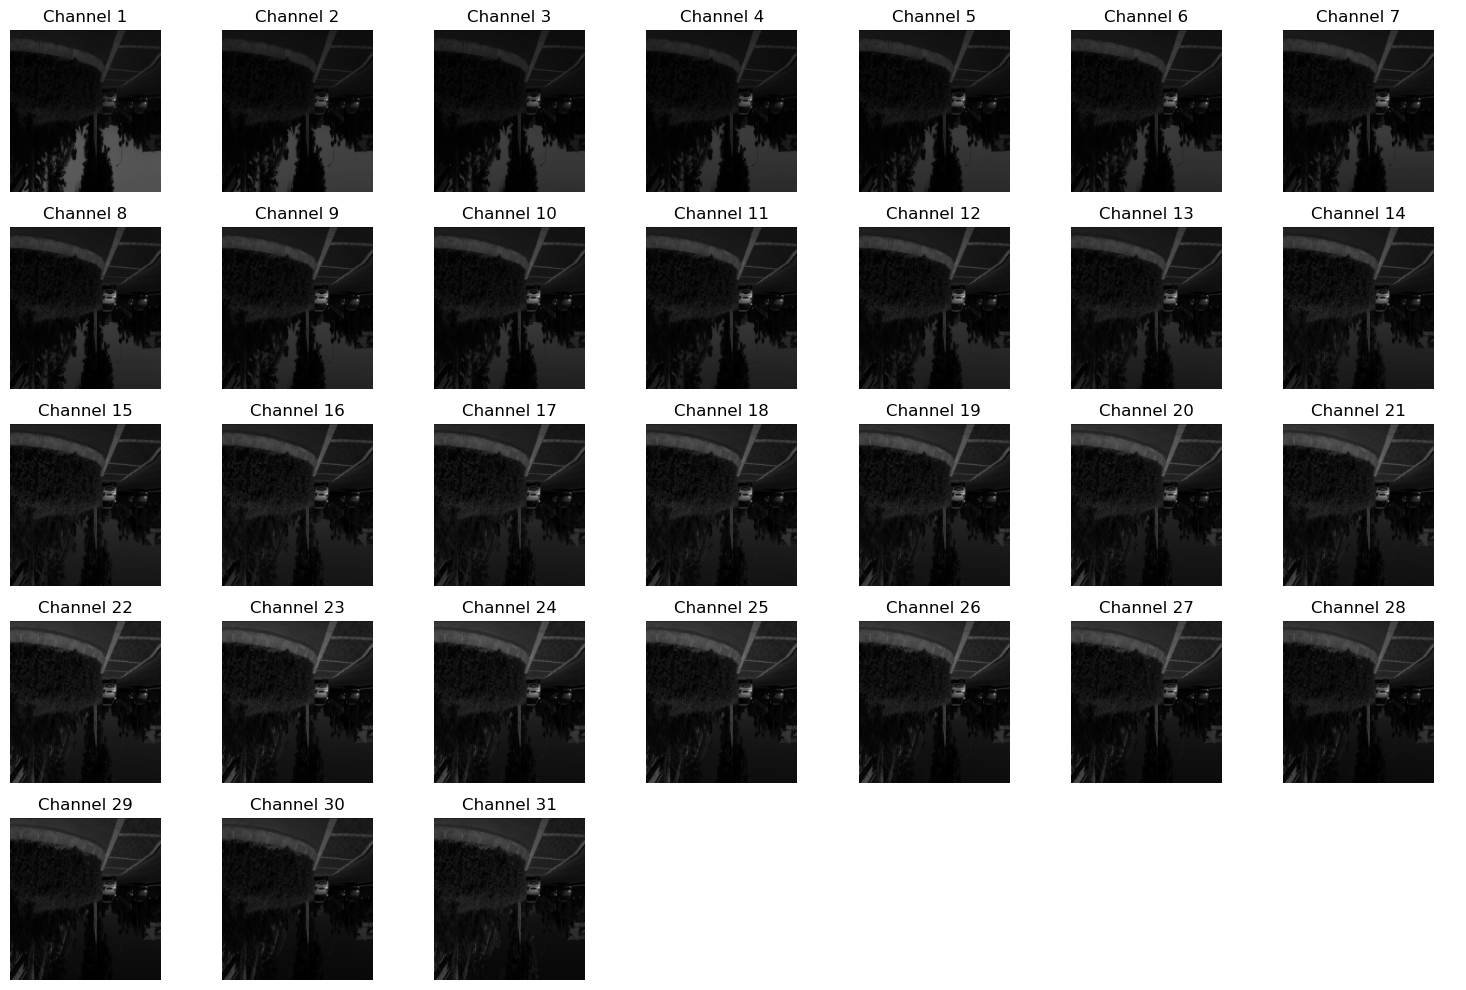

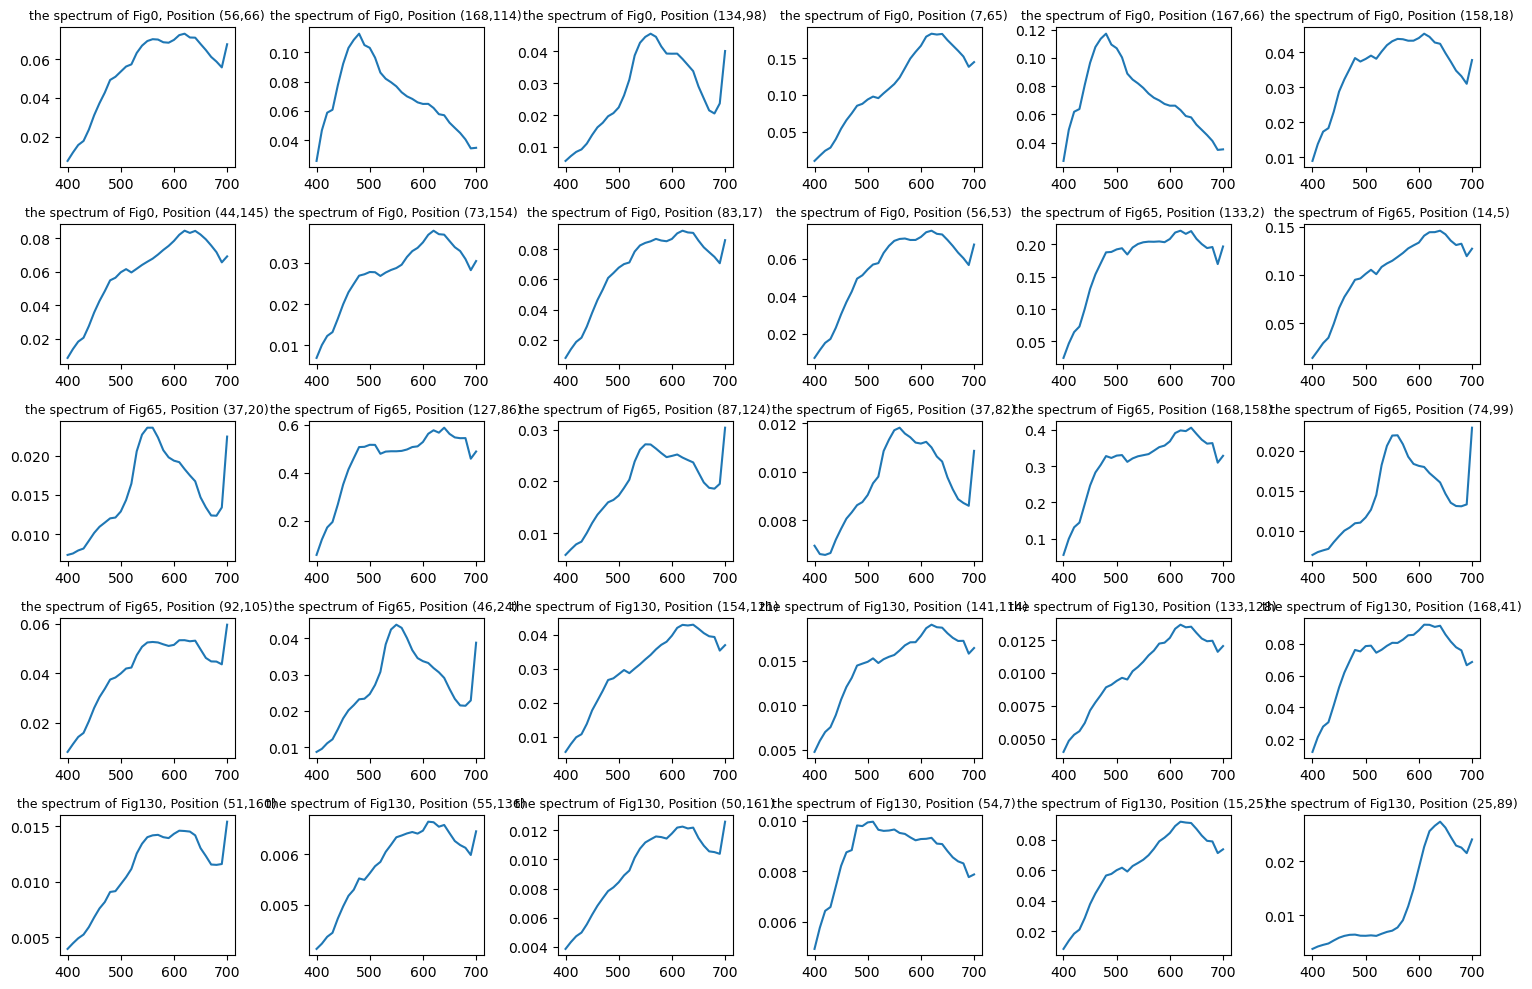

In [6]:
wavelengths = torch.linspace(400,700,31)
#visualize the 31 channels of the first image
fig, axes = plt.subplots(5, 7, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    if i < 31:
        ax.imshow(data_icvl[0,:, :, i], cmap='gray')
        ax.set_title(f'Channel {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()
#visualize 10 spectra of 10 randomly selected positions of three graphs 0,65,130
num_pos = 30
x_pos= np.random.randint(0, n_x, num_pos)
y_pos = np.random.randint(0, n_y, num_pos)

#select the graph
graphs_selected=[0,65,130]

#draw the spectra
fig, axes = plt.subplots(5, 6, figsize=(15, 10))
for idx, (i, j, ax) in enumerate(zip(x_pos, y_pos, axes.flat)):
    spectrum = data_icvl[int(idx/10), i, j, :]
    ax.plot(wavelengths,spectrum)
    ax.set_title(f'the spectrum of Fig{graphs_selected[int(idx/10)]}, Position ({i},{j})',fontsize=9)
    ax.axis('on')
plt.tight_layout()
plt.show()

The next thing we want to prepare is to split our dataset into two distinct datasets for training and testing, e.g. at a ratio of 80:20.

> - **Task 1.2** Split the ICVL dataset into train and test sets.

In [7]:
batch_size=32
def train_val_test_split(datapoints, labels, train_size=0.8, val_size=0.1, test_size=0.1, random_state=None):
    '''
    datapoints and labels are in np.array form, the datas are randomly distributed as train,val and test datasets
    according to the train_size,val_size,test_size.

    output: datapoints_train, labels_train, datapoints_val, labels_val, datapoints_test, labels_test, all are in np.array form
    '''
    assert train_size + val_size + test_size == 1, "Train, validation, and test sizes must sum to 1"

    datapoints_train, datapoints_temp, labels_train, labels_temp = train_test_split(
      datapoints, labels, train_size=train_size, random_state=random_state)

    relative_val_size = val_size / (val_size + test_size)

    datapoints_val, datapoints_test, labels_val, labels_test = train_test_split(
      datapoints_temp, labels_temp, train_size=relative_val_size, random_state=random_state)

    return datapoints_train, labels_train, datapoints_val, labels_val, datapoints_test, labels_test
#split the data into train, validation and test dataset with 8:1:1
TR_img,TR_y,val_img,val_y,te_img,te_y=train_val_test_split(data_icvl,data_icvl,random_state=42)
#merge the val and test dataset as  one single test dataset
TE_img=torch.cat((val_img,te_img),axis=0)
TE_y=torch.cat((val_y,te_y),axis=0)
#create the dataloader for train,val and test dataset
train_dataset = TensorDataset(TR_img,TR_y)
val_dataset = TensorDataset(val_img, val_y)
te_dataset = TensorDataset(te_img, te_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
te_loader = DataLoader(te_dataset, batch_size=batch_size, shuffle=False)

---
# 2. RGB to Hyperspectral
---

### Prinicipal Component Analysis (PCA)

Before looking at RGB measurements let us explore the hyperspectral data a bit using Principal component analysis.

Disregarding the spatial arrangement in a number of images $S_i(x,y,\lambda)$, we can just treat the dataset as a list of spectra $S_n(\lambda)$, or more generally as a $n\times p$ data matrix $\mathbf{X}$, for $n$ realizations of $p$-dimensional vectors

Thinking of these vectors as sampled data from a hypothetical distribution, intuitively we can say each sample would be made up of the mean of the distribution plus some variance.
Without loss of generality, we can *center* the data by substracting the empirical mean, thus setting it to zero.
Now for any centered data $\mathbf{X}$ we can compute the empirical covariance matrix as
$$\mathrm{cov}(X_i,X_j) = \mathbf{X}^{\intercal}\mathbf{X}$$

As this is a square matrix, we can transform it like
$$\mathbf{X}^{\intercal}\mathbf{X} = \mathbf{W}\mathbf{\Lambda}\mathbf{W}^{\intercal}$$

with the columns of $\mathbf{W}$ containing the eigenvectors of the covariance (the principal components) and $\mathbf{\Lambda}$ being a diagonal matrix containing the corresponding eigenvalues.

This transformation allows us to express the data in a coordinate system that represents the observed variance better.
Crucially, for most datasets the eigenvalues will vary in magnitude. Other than giving insight into the structure of the data, this allows for a more efficient representation.


> - **Task 2.1** Compute the principal components of the training dataset
> - **Task 2.2** Visualize the explained variance as a function of number of principal components. Discuss the result
>  - **On Task 2.2** Let $\mathbf S$ denote the original 31-dim random vector corresponding to the discretized spectrum and $\mathbf X$ denote the centered version of it. The matrix mapping $mathbf X$ to its PCA conponents $\mathbf T$:
$$
\mathbf T=W^{\intercal} \mathbf X
$$
is a linear, non-singular, O(p) matrix. The PCA components satisfies
$$
\mathrm{cov}(T_i,T_j)=\lambda_i \delta_{ij}
$$
where $\lambda_i$ is the i th largest eigenvalue of the covariance matrix of $\mathbf X$. The cell below plots the relation between $\lambda_i$ and i. As $i$ becomes larger, $\lambda_i$ decays fast and even faster than exponentially decay. Let $\gamma_j$ be
$$
\gamma_j\equiv\dfrac{\sum_{i=1}^j \lambda_i}{\sum_{i=1}^{p} \lambda_i},
$$
which quantifies the amount of contributions of the first $j$ components to the differences between two specturms $\mathbf s_1$ and $\mathbf s_2$. To see this more explicitly, let $\mathbf s_1$ and $\mathbf s_2$ be two randomly selected realizations of $\mathbf S$, then
$$
|\mathbf s_1-\mathbf s_2|^2=|\mathbf x_1-\mathbf x_2|^2=|\mathbf t_1-\mathbf t_2|^2=|\mathbf t_1-\mathbf t_2|^2\cdot\left(\dfrac{\sum_{i=1}^j (t_{1i}-t_{2i})^2}{|\mathbf t_1-\mathbf t_2|^2}+\dfrac{\sum_{i=j+1}^{p} (t_{1i}-t_{2i})^2}{|\mathbf t_1-\mathbf t_2|^2}\right),
$$
since $(t_{1i}-t_{2i})^2\sim2\mathrm{cov}(T_i,T_i)=2\lambda_i$, thus $\frac{\sum_{i=1}^j (t_{1i}-t_{2i})^2}{|\mathbf t_1-\mathbf t_2|^2}\sim\gamma_j$, $\gamma_j$ indeed quantifies the amount of contributions of the first $j$ components to the differences. The cell below also plots the $\gamma_j \sim j$ relation.  As $j$ increases, $\gamma_j$ increases very fast, the first components can explain $95\%$ of the differences, the largest three can explain $99.8\%$ of the differences, suggesting that in our case, the spectra can be compressed in an very efficient way by just preserving the first three principal components. Practically, any spectrum $\mathbf s$ can be compressed in the way below
$$
\mathbf t=W^{\intercal}(\mathbf s-\langle\mathbf S\rangle_{\text{train}})[:3] 
$$
where $\mathbf t$ is the compressing result, $\langle\mathbf S\rangle_{\text{train}}$ is the mean of $\mathbf S$ computed from the training set, '[:3]' means only preserving the first three components. To reconstruct the spectrum from $\mathbf t$, we can first extend $\mathbf t$ to be a $p$ dimentional vector $\mathbf t_{\text{ext}}$ by filling zeros into the vectors, then apply the transformation below to obtain the reconstructed spectrum $\mathbf s_{\text{recons}}$
$$
\mathbf s_{\text{recons}}=W\mathbf t_{\text{ext}}+\langle\mathbf S\rangle_{\text{train}}.
$$
The cell below further computes the MSE and PSNR between spectra reconstruacted by the first three principal components and the original spectra. Both MSE is around $3\times10^{-5}$, demonstrating a very high compressing quality considering that the typical magnitude of the spectra `torch.abs(data_icvl).mean()` is around 0.12.



training set: MSE and PSNR between spectra of the reconstructed by the first three components and the original ones: 3.09106642320849e-05, 45.09891662383162
test set: MSE and PSNR between spectra of the reconstructed by the first three components and the original ones: 2.9682074042312566e-05, 45.275057558976954


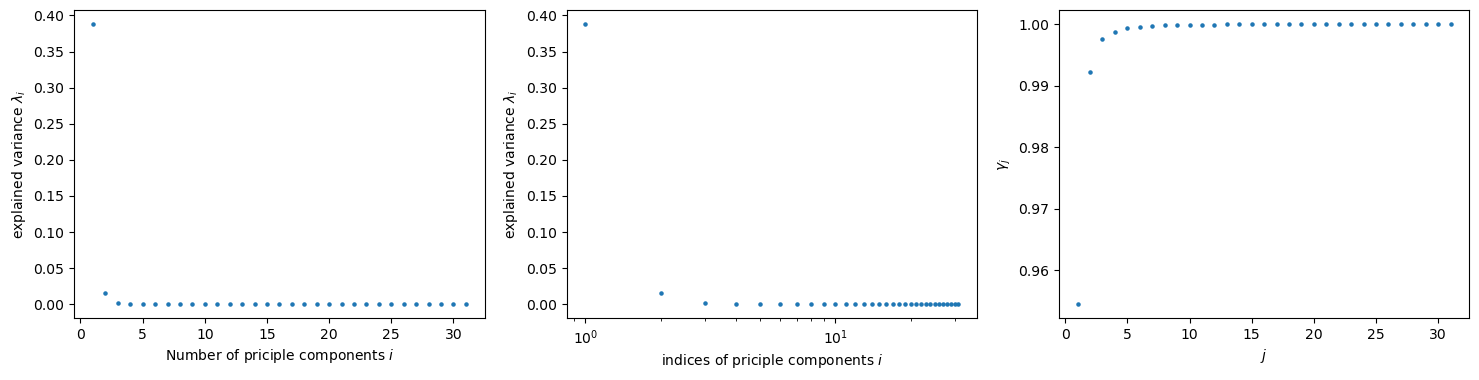

In [8]:
def pca(D, n_components):
    """
    Perform Principal Component Analysis (PCA) on the input data.

    Parameters:
    D : np.array
        Input data array of shape (Batch_num, ...), where the rest of the dimensions 
        represent the features. This array will be flattened to shape (Batch_num, n_features).
    n_components : int
        Number of principal components to compute.

    Returns:
    components : np.array
        PCA component matrix of shape (n_components, n_features). Each row is a principal component.
    img_mean : np.array
        Mean of the features, shape (1, n_features).
    img_std : np.array
        Standard deviation of the features, shape (1, n_features).
    explained_variance : np.array
        Variance explained by each of the selected components, shape (n_components,).
    """
    # Flatten the input array
    D = D.reshape(len(D), -1)
    
    # Calculate mean and standard deviation
    D_mean = (D.mean(axis=0)).reshape(1, -1)
    D_std = (D.std(axis=0)).reshape(1, -1)
    
    # Standardize the spectras
    X = (D - np.ones((len(D), 1)) @ D_mean)  #/ spectra_std
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca.fit(X)
    coefficients = pca.transform(X)
    components = pca.components_  # (n_components, n_features)
    explained_variance = pca.explained_variance_
    
    return components, D_mean,  explained_variance #spectra_std,
def pca_compress(pca_coe,D_mean,D,n_components):
    D = D.reshape(len(D), -1)
    X=(D - np.ones((len(D), 1)) @ D_mean)
    T=(pca_coe@X.T).T
    return T[:,:n_components]
def pca_inv(pca_coe,D_mean,T):
    T = T.reshape(len(T), -1)
    T_ext=np.zeros((len(T),pca_coe.shape[1]))
    T_ext[:,:T.shape[1]]=T
    X=(pca_coe.T@T_ext.T).T
    D=(X + np.ones((len(T), 1)) @ D_mean)
    return D
    

#reshape the data as (N,n_spectra)
TR_spectra,val_spectra,te_spectra,TE_spectra=(TR_img.reshape(-1,n_lambda)).numpy(),(val_img.reshape(-1,n_lambda)).numpy(),(te_img.reshape(-1,n_lambda)).numpy(),(TE_img.reshape(-1,n_lambda)).numpy()
#apply the PCA
pca_coe,spectra_mean,explained_variance=pca(TR_spectra,n_lambda)
cumulative_sum = np.cumsum(explained_variance)
#visualize the explained variance

fig, axes = plt.subplots(1, 3, figsize=(18,4))
for i,ax in enumerate(axes.flat):
    if i==1:
        ax.scatter(np.linspace(1,n_lambda,n_lambda),explained_variance,s=5)
        ax.set_ylabel('explained variance $\lambda_i$')
        ax.set_xlabel('indices of priciple components $i$')
        ax.set_xscale('log')
    elif i==0:
        ax.scatter(np.linspace(1,n_lambda,n_lambda),explained_variance,s=5)
        ax.set_ylabel('explained variance $\lambda_i$')
        ax.set_xlabel('Number of priciple components $i$')
    else:
        ax.scatter(np.linspace(1,n_lambda,n_lambda),cumulative_sum/explained_variance.sum(),s=5)
        ax.set_ylabel('$\gamma_j$')
        ax.set_xlabel('$j$')

# For both training and test dataset, compress the spectra to the first three principal components, 
#then reconstruct the spectra by setting other components to be zero, compute the MSE and PSNR between the reconstructed and the original.
for spectra,name in zip([TR_spectra,TE_spectra],['training','test']):
    T=pca_compress(pca_coe,spectra_mean,spectra,3)
    recons_spectra=pca_inv(pca_coe,spectra_mean,T)
    print(name+f' set: MSE and PSNR between spectra of the reconstructed by the first three components and the original ones: {((recons_spectra-spectra)**2).mean()}, {PSNR(recons_spectra,spectra,use_torch=False)}')

> - **Task 2.3** How can you use the results above to represent the images more efficiently? How well does that work?

### Generating RGB images

The red, green and blue pixels of a camera condense the complex spectral information in a scene into just three numbers. In recording an image, the detectors at each camera pixel integrate all spectral components $S(\lambda)$ of the impinging light. In an RGB camera the color pixel's quantum efficiency $Q(\lambda)$ determines the weight of each spectral component resulting in the equation for the recorded fluence in color channel $c$ being:
$$
F_c = \int_{0}^{∞} Q_c(\lambda)S(\lambda)\mathrm{d}\lambda
$$

The following shows the quantum efficiencies of the individual color pixels in an industrial Sony IMX camera.

(0.0, 100.0)

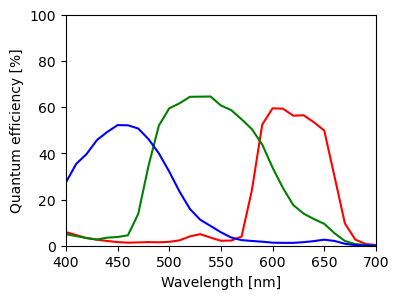

In [9]:
wavelengths = torch.linspace(400,700,31)

qe_red = torch.tensor([0.0591, 0.0459, 0.0332, 0.0261, 0.0205, 0.0157, 0.0131, 0.0144, 0.0157, 0.0148, 0.0168, 0.0233, 0.0405, 0.05, 0.0351, 0.0215, 0.0223, 0.0395, 0.2407, 0.5243, 0.5949, 0.5934, 0.5629, 0.5648, 0.5345, 0.4987, 0.2988, 0.0965, 0.0267, 0.0076, 0.003 ])
qe_green = torch.tensor([0.0501, 0.0416, 0.0331, 0.0269, 0.0349, 0.0378, 0.0451, 0.138, 0.3471, 0.5207, 0.5947, 0.6165, 0.6446, 0.6452, 0.646 , 0.607, 0.5869, 0.5475, 0.5045, 0.4381, 0.3381, 0.2501, 0.1762, 0.1392, 0.1153, 0.0948, 0.054 , 0.0204, 0.0074, 0.0027, 0.0013])
qe_blue = torch.tensor([2.738e-01, 3.546e-01, 3.969e-01, 4.573e-01, 4.925e-01, 5.221e-01, 5.214e-01, 5.074e-01, 4.611e-01, 3.996e-01, 3.209e-01, 2.340e-01, 1.593e-01, 1.124e-01, 8.560e-02, 5.820e-02, 3.560e-02, 2.420e-02, 2.060e-02, 1.740e-02, 1.320e-02, 1.240e-02, 1.240e-02, 1.540e-02, 2.000e-02, 2.610e-02, 2.060e-02, 8.400e-03, 2.600e-03, 8.000e-04, 3.000e-04])

plt.figure(figsize=(4,3))

plt.plot(wavelengths, 100*qe_red,   color="red")
plt.plot(wavelengths, 100*qe_green, color="green")
plt.plot(wavelengths, 100*qe_blue,  color="blue")

plt.xlabel('Wavelength [nm]')
plt.ylabel('Quantum efficiency [%]')
plt.xlim(400,700)
plt.ylim(0,100)

It is often the case that the quantum efficiency is measured at discrete positions. Here the quantum efficiencies $ Q_c(\omega) $ and the spectral power distribution $ S(\omega) $ are given in a discretized form over 31 spectral bands, so the equation for the recorded fluence in color channel $ c $ can be approximated as a discrete sum instead of an integral. If the discretization results in $ n $ spectral bands, and we use the mid-point approximation for simplicity, the equation for $ F_c $ can be re-written as:

$$
F_c = \sum_{i=1}^{n} Q_c(\lambda_i) S(\lambda_i) \Delta \lambda
$$

where:
- $ Q_c(\lambda_i) $ is the quantum efficiency of the color channel $ c $ at the discrete wavelength $ \lambda_i $,
- $ S(\lambda_i) $ is the spectral power distribution at $ \lambda_i $,
- $ \Delta \lambda $ is the width of each spectral band (which is 10 nm in our case).

We can also write the above equation as a matrix multiplication. Firstly, we can represent the quantum efficiencies for all color channels as a single matrix $ Q $ of size $ 3 \times 31 $, where each row corresponds to a color channel (red, green, blue) and each column to a quantum efficiency value at a specific wavelength:
$$
Q = \begin{bmatrix}
qe_{red} \\
qe_{green} \\
qe_{blue} \\
\end{bmatrix}
$$
Given that $S(\lambda_i)$ is the spectral power distribution for a set of $N$ spectra at wavelength $\lambda_i$, let's arrange these spectra into a matrix $S$ where each column represents a spectrum and each row corresponds to a specific wavelength:
$$
S = \begin{bmatrix}
S(\lambda_1) & S(\lambda_1) & \cdots & S(\lambda_1) \\
S(\lambda_2) & S(\lambda_2) & \cdots & S(\lambda_2) \\
\vdots & \vdots & \ddots & \vdots \\
S(\lambda_{31}) & S(\lambda_{31}) & \cdots & S(\lambda_{31}) \\
\end{bmatrix}
$$
This matrix $S$ has a dimension of $31 \times N$.

The discrete version of the recorded fluence $F_c$ can be elegantly expressed as a matrix multiplication between $Q$ and $S$. Since $Q$ is $3 \times 31$ and $S$ is $31 \times N$, their product will yield a new matrix $F$ of dimensions $3 \times N$, where each row now represents the fluence for a specific color channel across $N$ different spectra:
$$
F = Q \cdot S
$$
Each element $F_{c,n}$ in the matrix $F$ corresponds to the fluence in color channel $c$ for the $n^{th}$ spectrum. Lastly, we need to include $\Delta \lambda$, the width of each spectral band (10 nm in this case). This constant can simply be factored into the multiplication:
$$
F = Q \cdot S \cdot \Delta \lambda
$$
This adjusts the scale of the fluence values appropriately according to the width of the spectral bands.

Given this information and the hyperspectral data we have from the ICVL dataset, we can *simulate* RGB color images.

>- **Task 2.4** Using the quantum efficiencies of the camera's RGB pixels, simulate recording the hyperspectral scenes with an RGB camera.

shape and rank of QE matrix:torch.Size([3, 31]),3


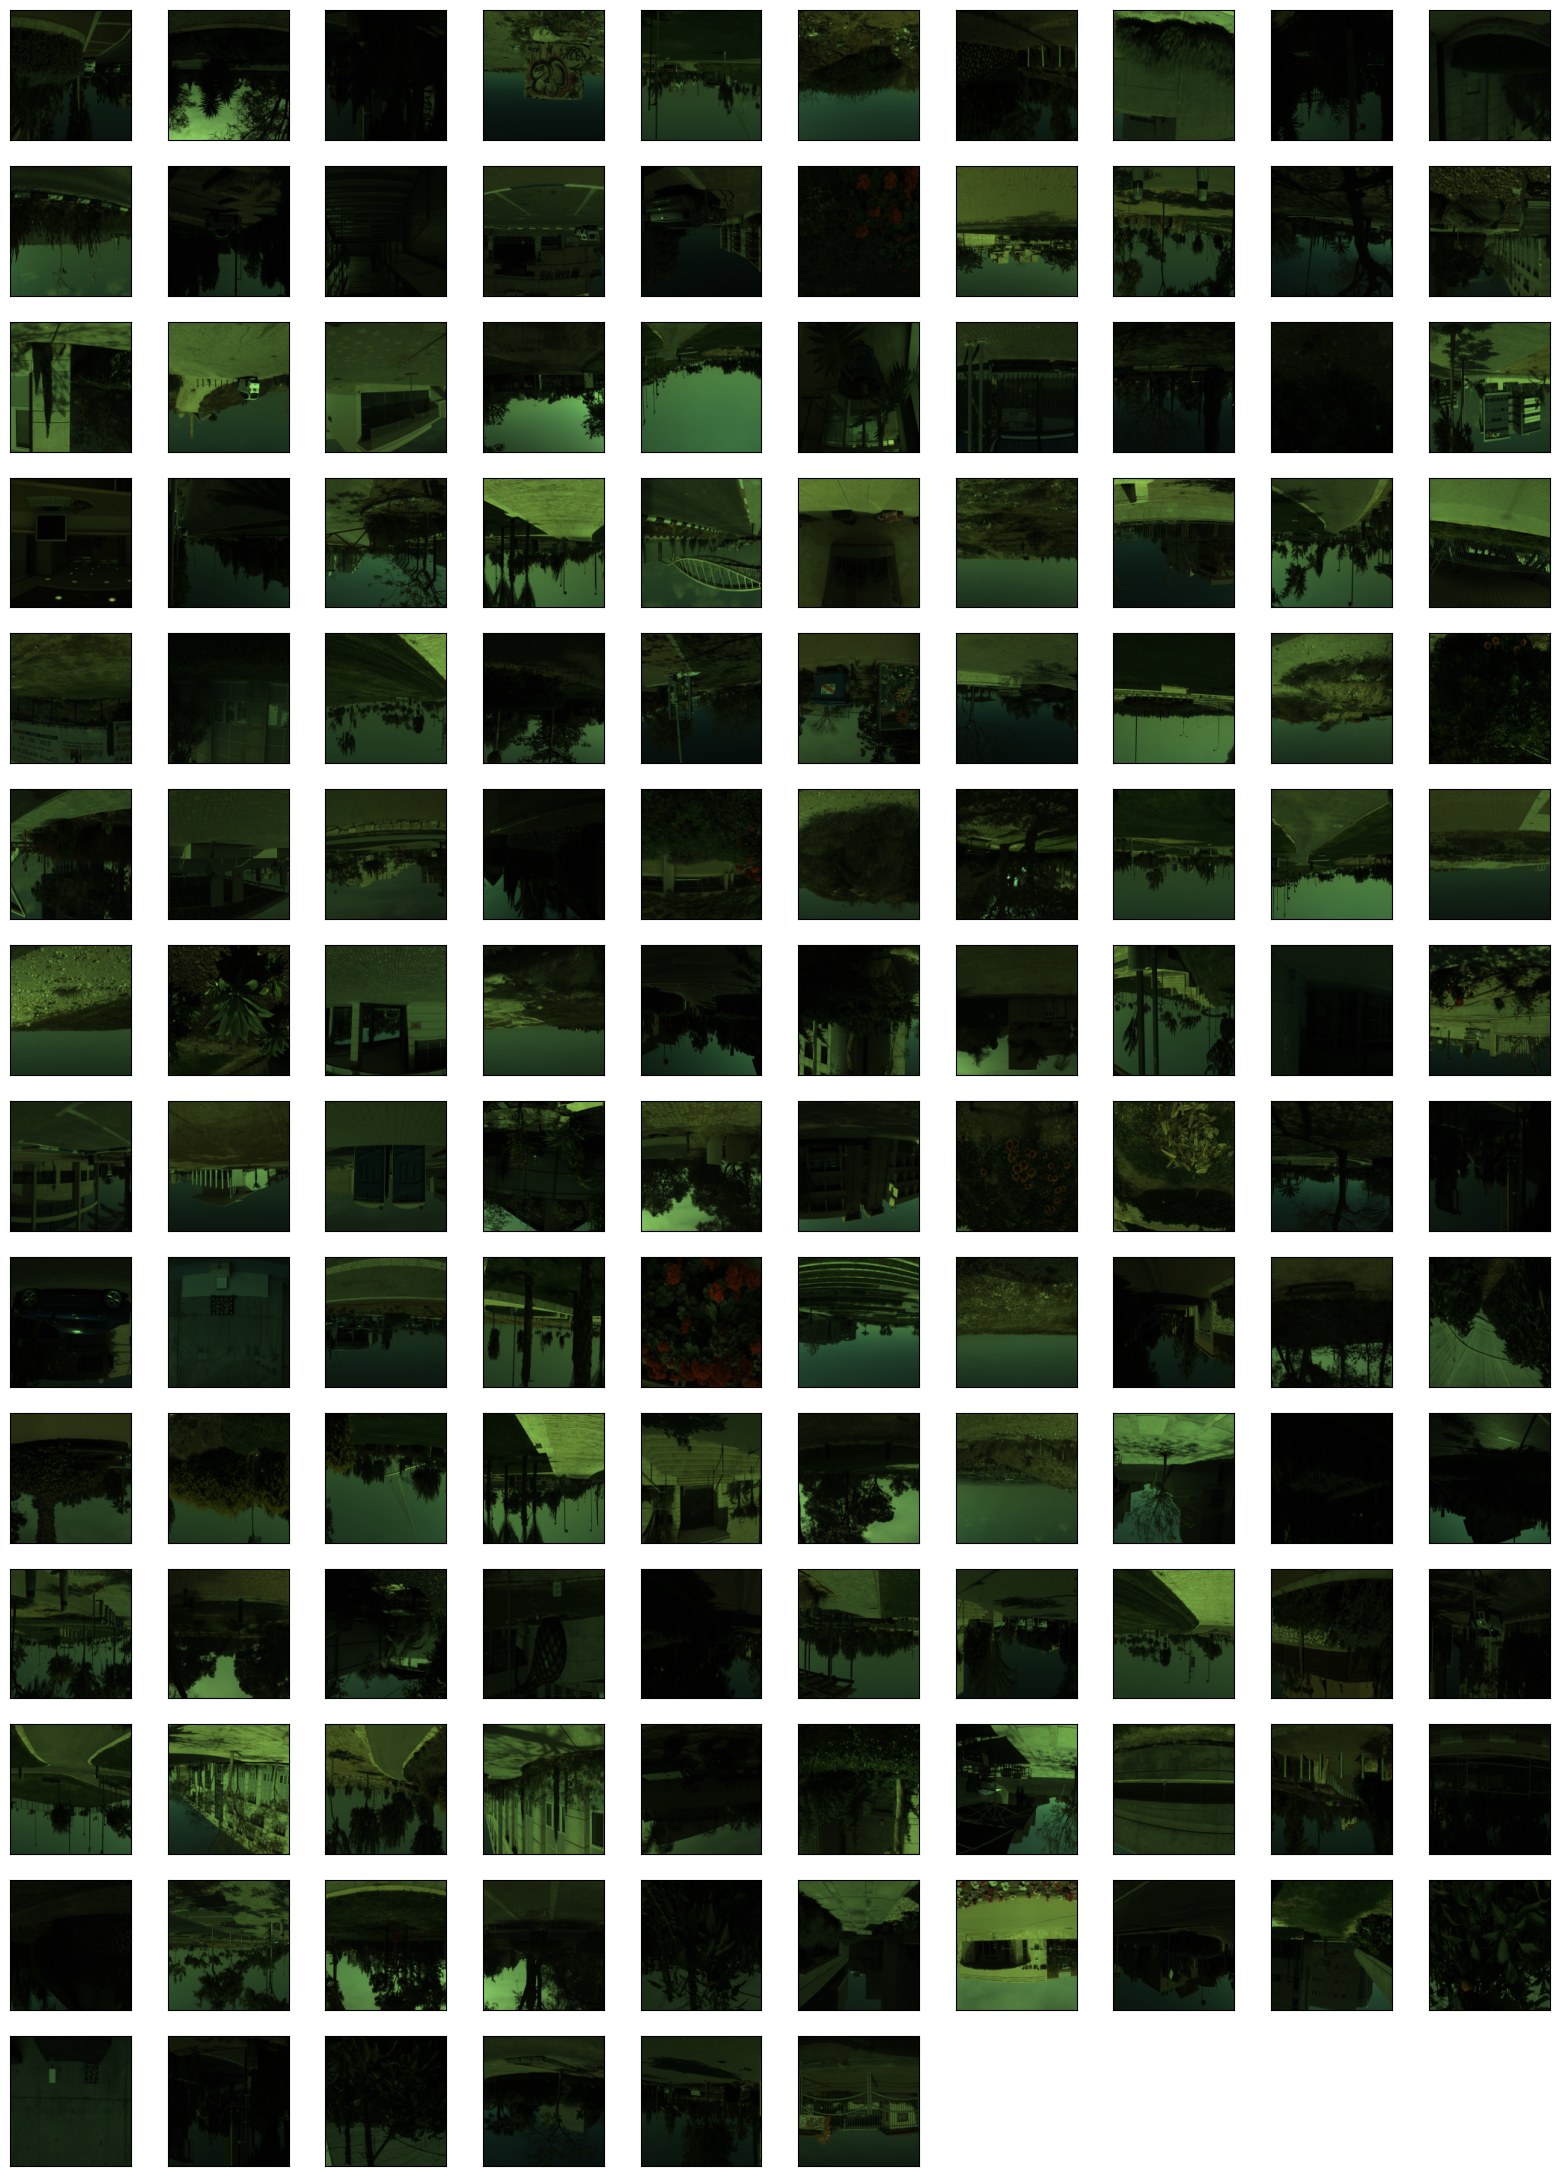

In [10]:
def S_to_F(QE,delta_lambda,S):
    #compute the F matrix
    delta_lambda=10 #nm
    S=torch.transpose(S,0,1)
    F=delta_lambda*torch.mm(QE,S)
    F=torch.transpose(F,0,1)
    return F
qe_red = torch.tensor([0.0591, 0.0459, 0.0332, 0.0261, 0.0205, 0.0157, 0.0131, 0.0144, 0.0157, 0.0148, 0.0168, 0.0233, 0.0405, 0.05, 0.0351, 0.0215, 0.0223, 0.0395, 0.2407, 0.5243, 0.5949, 0.5934, 0.5629, 0.5648, 0.5345, 0.4987, 0.2988, 0.0965, 0.0267, 0.0076, 0.003 ])
qe_green = torch.tensor([0.0501, 0.0416, 0.0331, 0.0269, 0.0349, 0.0378, 0.0451, 0.138, 0.3471, 0.5207, 0.5947, 0.6165, 0.6446, 0.6452, 0.646 , 0.607, 0.5869, 0.5475, 0.5045, 0.4381, 0.3381, 0.2501, 0.1762, 0.1392, 0.1153, 0.0948, 0.054 , 0.0204, 0.0074, 0.0027, 0.0013])
qe_blue = torch.tensor([2.738e-01, 3.546e-01, 3.969e-01, 4.573e-01, 4.925e-01, 5.221e-01, 5.214e-01, 5.074e-01, 4.611e-01, 3.996e-01, 3.209e-01, 2.340e-01, 1.593e-01, 1.124e-01, 8.560e-02, 5.820e-02, 3.560e-02, 2.420e-02, 2.060e-02, 1.740e-02, 1.320e-02, 1.240e-02, 1.240e-02, 1.540e-02, 2.000e-02, 2.610e-02, 2.060e-02, 8.400e-03, 2.600e-03, 8.000e-04, 3.000e-04])
QE  = torch.stack([qe_red, qe_green, qe_blue])
#compute the shape and rank of QE
print('shape and rank of QE matrix:{},{}'.format(QE.shape,torch.linalg.matrix_rank(QE)))
delta_lambda=10
S=data_icvl.reshape((-1,n_lambda))
F=S_to_F(QE,delta_lambda,S)
F=torch.transpose(F,0,1)
#compute the RGB value
RGB=torch.transpose(F,0,1).reshape((n_img, n_x, n_y,3))
RGB255=(RGB/RGB.max()*255).to(torch.uint8)
#plot the htperspectral scenes captured by RGB camera
plt.figure(figsize=(20,28))
for i in range(136):
    plt.subplot(14,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(RGB255[i])
plt.show()

### Reconstructing hyperspectral images from RGB via matrix inversion

We have seen that we can generate the RGB images from a linear equation of the form $A\mathbf{x}=\mathbf{y}$. Here $A$ acts as projection matrix from the hyperspectral space $\mathbf{x}$ to the RGB space $\mathbf y$ using the quantum efficiency matrix $Q$ and the bin width $\delta \lambda$. The question arises if we can infer the original hyperspectral images using matrix inversion, i.e.
$$
\mathbf{x}=A^{-1}\mathbf{y}
$$

- **Task 2.5** Can you directly invert the linear equation? Try to reconstruct the hyperspectral images from the RGB images. How well does that work? Calculate the peak signal to noise ratio (PSNR) between the reconstruction and the original spectra using the test dataset.

 **On task 2.5** Since $Q$ is not of shape $N\times N$, thus it's not invertible. However we may use its [pseudoinverse (Moore-Penrose inverse)](https://www.cambridge.org/core/journals/mathematical-proceedings-of-the-cambridge-philosophical-society/article/generalized-inverse-for-matrices/5F4516D6B9989BB6563A4B267CC7D615) $Q^+$, which maps each datapoint $\mathbf y$ in $\mathbb R^3$ to one of the points in the preimage of $\mathbf y$ under the map $A$,to map the (red,green,blue) vector back. The PSNR between the reconstruction and the original images is 23.1438, indicating the square root of MSE between them is of the same order of the spectral intensity, which is between 0.033 and 1. The recontruction is bad by directly inverting the $Q$. This result is expected. Suppose there is indeed a large redundance in the degree of freedom of our spectra, then the manifold $\mathcal S$ formed by all the 31-dim spetra vectors are only an inserted manifold of $\mathbb R^{31}$ with smaller dimentions. On average, $Q^+$ maps each point $\mathbf y$ in $\mathbb R^3$ to one point in the preimage $Q^{-1}[\mathbf y]$, a 10-dim subspace of $R^{31}$ on average, since $\dim(\mathcal S)<31$, the points of $\mathcal S$ in $Q^{-1}[\mathbf y]$ only forms a surface with dimention less than 10, thus it's very difficult for $Q^+(\mathbf y)$ to hit the points of $\mathcal S$.

In [11]:
#conpute the pseudoinverse
QE_inv=torch.linalg.pinv(QE)
#reconstruct the HB image
data_reconstruct=torch.transpose(torch.mm(QE_inv,F/delta_lambda),0,1).reshape((n_img, n_x, n_y,n_lambda))
#Calculate the peak signal to noise ratio (PSNR)
print('PSNR:{}'.format(PSNR(data_reconstruct,data_icvl)))

PSNR:23.143783569335938


### Reconstruction using PCA

- **Task 2.6** Can you exploit the transformation to/from the PCA basis to achieve a better reconstruction?
-  **On Task 2.6** Let $\mathbf F$ be the random vector of the RGB, let $\mathbf f$ denote its realization. By utilizing the PCA transoformation, the $\mathbf f$ is mapped back to the spectrum $\mathbf s$ by two steps:
    - 1.  Mapping $\mathbf f$ to the first three principal components $\mathbf t$:
            $$
            \mathbf f\leftarrow\frac{\mathbf f}{\max_{\text{train}}(\mathbf F)},\\
            \mathbf t=K\mathbf f+\mathbf b.
            $$
            The weight matrix $K$ and the bias $\mathbf b$ are fit by the linear regression, $\max_{\text{train}}(\mathbf F)$ is the maximum value among the values of all the components of the $F$ matrix of the training set. 
    - 2. Mapping $\mathbf t$ to $\mathbf s$ through the same way as Task2.3 and 2.3.
The cell below further computes the MSE and PSNR between spectra reconstruacted by the RGB exploiting the PCA tranformation and the original spectra. Both MSE is around $4.35\times10^{-5}$ which is higher than pure PCA reconstruction by around $40\%$, but still demonstrating a very high compressing quality.
  



In [12]:
#prepare the principal components of the training set
TR_T=pca_compress(pca_coe,spectra_mean,TR_spectra,3)
TR_F,val_F,te_F,TE_F=S_to_F(QE,delta_lambda,torch.as_tensor(TR_spectra)),S_to_F(QE,delta_lambda,torch.as_tensor(val_spectra)),S_to_F(QE,delta_lambda,torch.as_tensor(te_spectra)),S_to_F(QE,delta_lambda,torch.as_tensor(TE_spectra))
#normalize F
F_max=TR_F.numpy().max()
TR_F,val_F,te_F,TE_F=TR_F.numpy()/F_max,val_F.numpy()/F_max,te_F.numpy()/F_max,TE_F.numpy()/F_max
#fit a linear model mapping F'=F/F.max() to the first three principal components
F_to_T=LinearRegression().fit(TR_F,TR_T)
#map F to the first three principal components
TE_TfromF,TR_TfromF=F_to_T.predict(TE_F),F_to_T.predict(TR_F)
TE_reconsS,TR_reconsS=pca_inv(pca_coe,spectra_mean,TE_TfromF),pca_inv(pca_coe,spectra_mean,TR_TfromF)
#calculate the MSE and PSNR
for spectra,recons_spectra,name in zip([TR_spectra,TE_spectra],[TR_reconsS,TE_reconsS],['training','test']):
    print(name+f' set: MSE and PSNR between spectra of the reconstructed by the RGB and the original ones: {((recons_spectra-spectra)**2).mean()}, {PSNR(recons_spectra,spectra,use_torch=False)}')

training set: MSE and PSNR between spectra of the reconstructed by the RGB and the original ones: 4.443509611242567e-05, 43.522738761224474
test set: MSE and PSNR between spectra of the reconstructed by the RGB and the original ones: 4.305613639438752e-05, 43.659649438083946


### Fully connected neural network

While the PCA-based approach provides a linear transformation for reconstructing hyperspectral data from RGB measurements, we can also explore non-linear mappings using neural networks. A fully connected neural network, also known as a multi-layer perceptron (MLP), can be used to learn the complex relationship between RGB values and their corresponding hyperspectral representations.

An MLP consists of multiple layers of interconnected nodes or neurons. Each neuron in a layer receives weighted inputs from the neurons in the previous layer, applies an activation function, and passes the output to the neurons in the next layer. The weights of the connections between neurons are learned during the training process using optimization algorithms such as gradient descent.

For the task of reconstructing hyperspectral data from RGB measurements, we can design an MLP with the following architecture:

- Input layer: The input layer consists of three neurons, corresponding to the red, green, and blue (RGB) values of a pixel.
- Hidden layers: One or more hidden layers can be added to introduce non-linearity and capture complex relationships between the RGB values and the hyperspectral data. The number of neurons in each hidden layer can be determined based on the complexity of the problem and the available computational resources.
- Output layer: The output layer consists of neurons corresponding to the number of spectral bands in the hyperspectral data. Each neuron in the output layer represents the reconstructed value for a specific spectral band.

---
<details>

<summary>Primer on mathematics of neural nets</summary>

<div align="center">
    <img src="https://upload.wikimedia.org/wikipedia/commons/3/3d/Neural_network.svg" width="400"/>
</div>

Mathematically, we can represent an MLP with $L$ layers as a sequence of linear transformations followed by non-linear activation functions. Let's denote the input RGB values as $\mathbf{x} \in \mathbb{R}^3$, and the output of the $l$-th layer as $\mathbf{h}^{(l)}$. The transformation from the input to the first hidden layer can be written as:

$$
\mathbf{h}^{(1)} = f^{(1)}(\mathbf{W}^{(1)}\mathbf{x} + \mathbf{b}^{(1)})
$$

where $\mathbf{W}^{(1)} \in \mathbb{R}^{d_1 \times 3}$ is the weight matrix, $\mathbf{b}^{(1)} \in \mathbb{R}^{d_1}$ is the bias vector, and $f^{(1)}$ is the activation function for the first layer. The output dimension of the first layer is $d_1$.

The Rectified Linear Unit (ReLU) is a commonly used activation function in MLPs. It is defined as:

$$
\text{ReLU}(x) = \max(0, x)
$$

The ReLU function introduces non-linearity into the network by setting negative values to zero, while keeping positive values unchanged.

The subsequent hidden layers can be represented similarly:

$$
\mathbf{h}^{(l)} = f^{(l)}(\mathbf{W}^{(l)}\mathbf{h}^{(l-1)} + \mathbf{b}^{(l)})
$$

where $\mathbf{W}^{(l)} \in \mathbb{R}^{d_l \times d_{l-1}}$ is the weight matrix, $\mathbf{b}^{(l)} \in \mathbb{R}^{d_l}$ is the bias vector, and $f^{(l)}$ is the activation function for the $l$-th layer. The output dimension of the $l$-th layer is $d_l$.

The final output layer, which produces the reconstructed hyperspectral data $\hat{\mathbf{x}} \in \mathbb{R}^{n_\lambda}$, can be written as:

$$
\hat{\mathbf{x}} = \mathbf{W}^{(L)}\mathbf{h}^{(L-1)} + \mathbf{b}^{(L)}
$$

where $\mathbf{W}^{(L)} \in \mathbb{R}^{n_\lambda \times d_{L-1}}$ is the weight matrix, $\mathbf{b}^{(L)} \in \mathbb{R}^{n_\lambda}$ is the bias vector, and $n_\lambda$ is the number of spectral bands in the hyperspectral data.

By stacking multiple layers with non-linear activation functions, MLPs can learn complex, non-linear mappings between RGB values and hyperspectral data. During training, the weights and biases of the network are learned using backpropagation and optimization algorithms to minimize a loss function, such as the mean squared error (MSE) between the reconstructed hyperspectral data and the ground truth.

</details>

---


The MLP can be trained using a dataset consisting of RGB values as inputs and their corresponding hyperspectral data as targets. The training process involves iteratively updating the weights of the network to minimize a loss function, such as the mean squared error (MSE) between the reconstructed hyperspectral data and the ground truth.

During training, the RGB values from the training set are fed into the input layer, and the network predicts the corresponding hyperspectral data. The predicted output is compared with the ground truth hyperspectral data, and the loss is calculated. The gradients of the loss with respect to the weights are computed using backpropagation, and the weights are updated using an optimization algorithm such as stochastic gradient descent (SGD) or Adam.

Once the MLP is trained, it can be used to reconstruct hyperspectral data from RGB measurements in the test set. The RGB values from the test set are passed through the trained network, and the output layer provides the reconstructed hyperspectral data.

>- **Task 2.7** Implement an MLP for reconstructing hyperspectral data from RGB measurements. Experiment with different architectures (number of hidden layers and neurons) and hyperparameters (learning rate, batch size) to find the best configuration. Train the MLP on the training set and evaluate its reconstruction quality on the test set using PSNR. Compare the results with the PCA-based approach and discuss the advantages and limitations of using an MLP for hyperspectral reconstruction.

---

<details>
<summary>Expand for a PyTorch code example</summary>

```python
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.layers.append(nn.ReLU())
        
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Training loop
def train(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        for rgb, hyperspectral in train_loader:
            # Forward pass
            outputs = model(rgb)
            loss = criterion(outputs, hyperspectral)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    
    print("Training finished!")

# Example usage
input_size = 3  # RGB values
hidden_sizes = [64, 128, 256]  # Example hidden layer sizes
output_size = 31  # Number of spectral bands

model = MLP(input_size, hidden_sizes, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming you have a DataLoader called 'train_loader' for your training data
num_epochs = 50
train(model, train_loader, criterion, optimizer, num_epochs)
```
</details>

---

In [13]:
#define the model class
class AutoEncoder(nn.Module):
    """
    A convolutional autoencoder neural network for unsupervised learning of compressed representations of input data.

    Args:
        Ddroprate (list): List of dropout rates for each dense layer.
        Dtdroprate (list): List of dropout rates for each transposed dense layer.
        z_drop (float): Dropout rate for the latent space.
        activ (nn.Module): Activation function to use (default is Tanh).
        Dsize (list): List of layer sizes for the dense layers.
        z_dim (int): Dimension of the latent space.

    Attributes:
        activ (nn.Module): Activation function.
        input_shape (list): Shape of the input data.
        z_dim (int): Dimension of the latent space.
        z_drop (float): Dropout rate for the latent space.
        hidden (int): Number of channels in the deepest convolutional layer.
        Dlayers (nn.ModuleList): List of dense layers.
        Dtlayers (nn.ModuleList): List of transposed dense layers.
        out_dim (int): Flattened size of the output from the last convolutional layer.
        out_n_pix (int): Number of pixels in the output from the last convolutional layer.
        outD (nn.Linear): Linear layer mapping to the latent space.
        inD (nn.Linear): Linear layer mapping from the latent space.
        flatten (nn.Flatten): Flattening layer.

    Model Structure:
        - Encoder:
            - Fully connected dense layers:
                - Linear(input size, Dsize[0])
                - Dropout(Ddroprate[0])
                - Activation(activ)
                - Linear(Dsize[0], Dsize[1])
                - Dropout(Ddroprate[1])
                - Activation(activ)
                - ...
                - Linear(Dsize[-2], Dsize[-1])
                - Dropout(Ddroprate[-1])
                - Activation(activ)
            - Latent space layer:
                - Linear(Dsize[-1], z_dim)

        - Decoder:
            - Fully connected dense layers:
                - Linear(z_dim, Dsize[-1])
                - Dropout(z_drop)
                - Activation(activ)
                - Linear(Dsize[-1], Dsize[-2])
                - Dropout(Dtdroprate[-1])
                - Activation(activ)
                - ...
                - Linear(Dsize[1], Dsize[0])
                - Dropout(Dtdroprate[1])
                - Activation(activ)
                - Linear(Dsize[0], input size)

    """
    def __init__(self, 
                  Ddroprate=[0.,0.,0.,0.,0.,0.],Dtdroprate=[0.,0.,0.,0.,0.,0.],z_drop=0., activ=nn.Tanh(),
                 input_dim=31,Dsize=[128,64,32],z_dim=3):

        super(AutoEncoder, self).__init__()
        
        self.activ = activ
        self.input_dim=input_dim
        self.z_dim=z_dim
        self.z_drop=z_drop
        Dnum = len(Dsize)
        Ddroprate=Ddroprate[:Dnum]
        Dtdroprate=Dtdroprate[:Dnum]
        if z_drop!=0.:
            Dtdroprate[0]=0.
        self.Dlayers = nn.ModuleList()
        self.Dtlayers = nn.ModuleList()
        in_features=self.input_dim
        
        for i in range(Dnum):
            D=Dsize[i]
            self.Dlayers.append(nn.Linear(in_features, D))
            self.Dlayers.append(nn.Dropout(p=Ddroprate[i]))            
            self.Dlayers.append(self.activ)            
            in_features = D
        self.outD=nn.Linear(in_features,self.z_dim)
        self.inD=nn.Linear(self.z_dim,in_features)
        for i in range(len(Dsize)):
            D=Dsize[Dnum-i-2] if i!=Dnum-1 else self.input_dim
            self.Dtlayers.append(nn.Linear(in_features,D))
            self.Dtlayers.append(nn.Dropout(p=Dtdroprate[Dnum-i-1]))
            if i!= Dnum-1:
                self.Dtlayers.append(self.activ)                    
            in_features = D
        self.flatten = nn.Flatten()



    def encoder(self,x):
        for Dlayer in self.Dlayers:
            x = Dlayer(x)
        z=self.outD(x)
        return z
    def decoder(self,z):
        _x=(self.inD(z))
        _x=self.activ(nn.Dropout(p=self.z_drop)(_x))
        for Dlayer in self.Dtlayers:
            _x=Dlayer(_x)
        return _x
    def forward(self,x):
        z=self.encoder(x)
        _x=self.decoder(z)
        return _x,z

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# define the PINN loss
Q=QE*delta_lambda/F_max
Q=torch.transpose(Q,0,1).to(device)
MSEloss=nn.MSELoss()

def PINNloss(F,S,S_pred,Q,alpha=0.1):
    '''
    Compute the Physics-Informed Neural Network (PINN) loss, 
    which is the sum of the MSE loss between S_pred and S, and alpha times the MSE loss between F_pred and F.
    
    Parameters:
    F (torch.Tensor): The true normalized RGB values.
    S (torch.Tensor): The true spectra.
    S_pred (torch.Tensor): The predicted spectra from the neural network.
    Q (torch.Tensor): A constant matrix used to convert spectra to normalized RGB values.
    alpha (float): A weighting factor for the second loss component. Default is 0.1.

    Returns:
    torch.Tensor: The total loss, which is the sum of the MSE loss between S_pred and S, and alpha times the MSE loss between F_pred and F.
    '''
    MSEloss=nn.MSELoss()
    loss1=MSEloss(S_pred,S)
    F_pred=torch.mm(S_pred,Q)
    loss2=MSEloss(F_pred,F)
    return loss1+alpha*loss2,loss1
#Scan different hyperparameters
import pickle
import time
#set up the features and labels
TR_spectra,TE_spectra=torch.as_tensor(TR_spectra),torch.as_tensor(TE_spectra)
TR_F,TE_F=torch.as_tensor(TR_F),torch.as_tensor(TE_F)
#further devide the training set(80% of all datapoints) as training set(70%)+validation set(10%)
TR_num=TR_spectra.shape[0]
val_num=int(TR_num/8)
tr_num=TR_num-val_num
TR1_spectra,TR1_F,val1_spectra,val1_F=TR_spectra[:tr_num],TR_F[:tr_num],TR_spectra[tr_num:],TR_F[tr_num:]

#set up the fixed heperparameters
seed=42
weight_decay=5e-7
patience_lr=7
factor=0.3
epochs=200
batch_sizes=[2**6]#tr_num,1048576,131072,4096,8192,16384,32768,65536,262144,524288
patience=30

#set up the hyperparameters required to be scanned
count=23
alphas=(10**np.linspace(-1.5,2.5,18))[11:12]
Dsizes=[[512,512,256,256,128,128]]#,[16, 16, 32, 32, 64, 64],
lrs=[1e-4,1e-3,3e-4,3e-5]

#initiate the hyperparameter scanning, scan combinations of different MLP structures, batch_sizes and learning rate
for batch_size in batch_sizes:
    for alpha in alphas:
        for Dsize in Dsizes:
            hyperparameterss=[]
            best_results=[]
            tr_historys,val_historys=[],[]
            for lr in lrs:
                if  (Dsize==[16, 16, 32, 32, 64, 64] and alpha==alphas[0]) or (lr in [1e-4,1e-3,3e-4] and Dsize==[512,512,256,256,128,128] and alpha==alphas[0]):
                    continue
                lr=lr
                gc.collect()
                torch.cuda.empty_cache()
                if seed!=None:
                    np.random.seed(seed)
                    random.seed(seed)
                    torch.manual_seed(seed)
                    torch.cuda.manual_seed(seed)
                    torch.cuda.manual_seed_all(seed)

                train_dataset = TensorDataset(TR1_F,TR1_spectra)
                val_dataset = TensorDataset(val1_F,val1_spectra)
                test_dataset = TensorDataset(TE_F,TE_spectra)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=2**14, shuffle=False)
                test_loader = DataLoader(test_dataset, batch_size=2**14, shuffle=False)
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

                #initiate the model
                autoencoder = AutoEncoder(
                    activ=nn.ReLU(),
                    z_dim=3, 
                   Dsize=Dsize
                )
                autoencoder = autoencoder.to(device)

                best_model = copy.deepcopy(autoencoder)

                #initiate the optimizer
                optimizer = optim.Adam(autoencoder.parameters(),lr=lr,weight_decay=weight_decay)

                #set up the scheduler
                if isinstance(patience_lr, list):
                    scheduler=get_piecewise_scheduler(optimizer,patience_lr,factor)
                else:
                    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=factor,patience=patience_lr,threshold=1e-3)


                losses = []
                # Training loop with early stopping and learning rate scheduling
                best_loss = float('inf')
                best_tr_loss= float('inf')
                epochs_no_improve = 0

                global_train_loss = []
                global_val_loss = []
                test_losses=[]
                time_cost=[]

                #begin truaining
                start_time = time.time()
                for epoch in range(epochs):
                    autoencoder.train()
                    train_loss = 0.
                    train_metric=0.
                    for xtrb, ytrb in train_loader:
                        xtrb = xtrb.to(device)
                        ytrb=ytrb.to(device)
                        _x= autoencoder.decoder(xtrb)
                        # Compute reconstruction loss and metric of training set
                        rec_loss,metric = PINNloss(xtrb,ytrb,_x,Q,alpha)

                        optimizer.zero_grad()
                        rec_loss.backward()
                        optimizer.step()
                        train_loss += rec_loss.item()
                        train_metric+=metric.item()

                    train_loss /= len(train_loader)
                    train_metric/=len(train_loader)
                    global_train_loss.append([train_loss,train_metric])

                    autoencoder.eval()
                    val_loss = 0.
                    val_metric=0.
                    with torch.no_grad():
                        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                        for xvalb,yvalb in val_loader:
                            xvalb = xvalb.to(device)
                            yvalb = yvalb.to(device)
                            _x= autoencoder.decoder(xvalb)
                        # Compute reconstruction loss and metric of val set
                            rec_loss,metric = PINNloss(xvalb,yvalb,_x,Q,alpha)

                            val_loss += rec_loss.item()
                            val_metric+=metric.item()
                        val_loss /= len(val_loader)
                        val_metric/=len(val_loader)
                        if isinstance(patience_lr,list):
                            scheduler.step(epoch)
                        else:
                            scheduler.step(train_loss)
                            lr_ = optimizer.param_groups[0]['lr']
                        global_val_loss.append([val_loss,val_metric])
                        end_time=time.time()

                        #calculate the time elapsed from the beginning of the training
                        time_cost.append(end_time-start_time)

                        #calculate the test loss and metric
                        te_loss=0.
                        te_metric=0.
                        for xvalb,yvalb in test_loader:
                            xvalb = xvalb.to(device)
                            yvalb = yvalb.to(device)
                            _x= best_model.decoder(xvalb)
                        # Compute reconstruction loss of test set
                            rec_loss,metric = PINNloss(xvalb,yvalb,_x,Q,alpha)

                            te_loss += rec_loss.item()
                            te_metric+=metric.item()
                        te_loss /= len(test_loader)  
                        te_metric/=len(test_loader)
                        test_losses.append([te_loss,te_metric])
                        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f},Validation Metric:{val_metric:.8f}, Test Metric:{te_metric:.8f}, LR: {lr_:.3e},Time_cost:{end_time-start_time}")

                        # Early stopping and learning rate scheduling
                        if val_loss+1e-7 < best_loss:
                            best_loss = val_loss
                            best_model = autoencoder
                            epochs_no_improve = 0
                        elif train_loss>best_tr_loss+0.15:
                            epochs_no_improve = 0
                        else:
                            epochs_no_improve += 1
                            best_tr_loss=train_loss
                        if epochs_no_improve >= patience and epoch>=5:
                            print("Early stopping triggered")
                            break


                tr_losses,val_losses=global_train_loss,global_val_loss

                #compute the index coresponding to the best validation loss and validation metric
                min_index=val_losses.index(min(val_losses))
                min_index_tr=tr_losses.index(min(tr_losses))

                best_result=[tr_losses[min_index][0],val_losses[min_index][0],test_losses[min_index][0],
                             tr_losses[min_index][1],val_losses[min_index][1],test_losses[min_index][1],
                             time_cost[min_index],sum(p.numel() for p in best_model.parameters()),min_index]
                param_names = ['Dsize','lr','batch_size','alpha']

                hyperparameters=[Dsize,lr,batch_size,alpha]
                hyperparameters = dict(zip(param_names, hyperparameters))
                print('hypeparameters: ', hyperparameters)
                print('best results:',best_result)
                hyperparameterss.append(hyperparameters)
                best_results.append(best_result)
                tr_historys.append(tr_losses)
                val_historys.append(val_losses)

                #plot the loss curve of both Training and Validation loss
                tr_losses,val_losses=np.array(tr_losses),np.array(val_losses)
                total_epoch = range(1, len(tr_losses) + 1)
                plt.figure(figsize=(20, 6))
                plt.subplot(1,2,1)
                plt.loglog(total_epoch , tr_losses[:,0], 'b', label='Training loss(PINNloss)')
                plt.loglog(total_epoch , val_losses[:,0], 'r', label='Validation loss(PINNloss)')
                plt.title(f'Training and Validation Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                # plt.ylim([-2.,+1.])
                plt.legend()
                plt.subplot(1,2,2)
                plt.loglog(total_epoch , tr_losses[:,1], 'b', label='Training metric(MSEloss)')
                plt.loglog(total_epoch , val_losses[:,1], 'r', label='Validation loss(MSEloss)')
                plt.title(f'Training and Validation Metric')
                plt.xlabel('Epochs')
                plt.ylabel('Metric')
                # plt.ylim([-2.,+1.])
                plt.legend()     
                
                plt.show()

                gc.collect()
                torch.cuda.empty_cache()

                #save the hyperparameters and training results
                with open(f'datas/RGBPINN_14_hyper_{count}.pickle','wb') as f:
                    pickle.dump(hyperparameterss,f)
                with open(f'datas/RGBPINN_14_best_{count}.pickle','wb') as f:
                    pickle.dump(best_results,f)
                with open(f'datas/RGBPINN_14_tr_{count}.pickle','wb') as f:
                    pickle.dump(tr_historys,f)
                with open(f'datas/RGBPINN_14_val_{count}.pickle','wb') as f:
                    pickle.dump(val_historys,f)
                count+=1

Epoch 1, Train Loss: 0.00097419, Validation Loss: 0.00003273,Validation Metric:0.00003213, Test Metric:0.02843523, LR: 3.000e-05,Time_cost:124.20312547683716
Epoch 2, Train Loss: 0.00003103, Validation Loss: 0.00002724,Validation Metric:0.00002691, Test Metric:0.00003335, LR: 3.000e-05,Time_cost:256.3165211677551
Epoch 3, Train Loss: 0.00002873, Validation Loss: 0.00002679,Validation Metric:0.00002644, Test Metric:0.00003249, LR: 3.000e-05,Time_cost:379.31997632980347
Epoch 4, Train Loss: 0.00002802, Validation Loss: 0.00003121,Validation Metric:0.00002757, Test Metric:0.00003248, LR: 3.000e-05,Time_cost:725.3635437488556
Epoch 5, Train Loss: 0.00002760, Validation Loss: 0.00002651,Validation Metric:0.00002548, Test Metric:0.00003099, LR: 3.000e-05,Time_cost:1123.1867196559906
Epoch 6, Train Loss: 0.00002735, Validation Loss: 0.00002919,Validation Metric:0.00002615, Test Metric:0.00003138, LR: 3.000e-05,Time_cost:1514.5086152553558
Epoch 7, Train Loss: 0.00002707, Validation Loss: 0.00

hypeparameters:  {'Dsize': [16, 16, 32, 32, 64, 64], 'lr': 3e-05, 'batch_size': 64, 'alpha': 12.25279857382865}
best results: [2.7355666035309293e-05, 2.7434571222784143e-05, 3.225952030668256e-05, 2.7134976325757495e-05, 2.7364214266375104e-05, 3.208157318113081e-05, 41168.82367968559, 17730, 118]


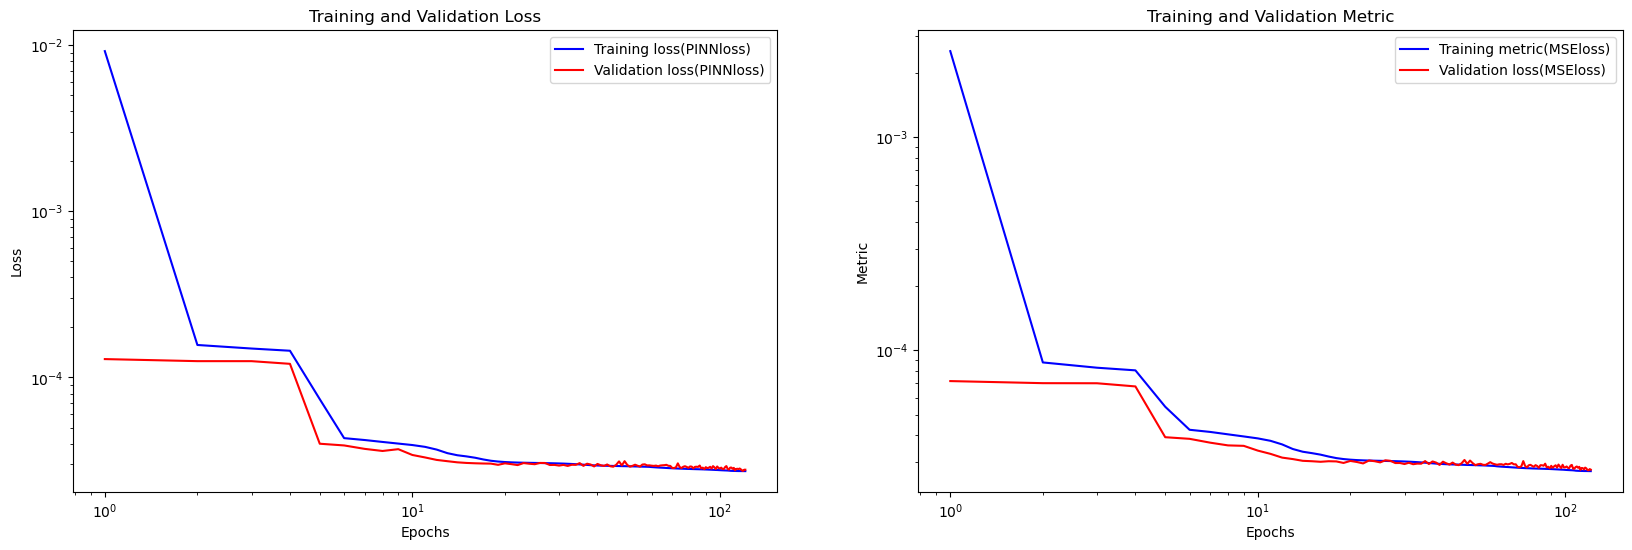

In [16]:
tr_losses,val_losses=global_train_loss,global_val_loss

#compute the index coresponding to the best validation loss and validation metric
min_index=val_losses.index(min(val_losses))
min_index_tr=tr_losses.index(min(tr_losses))

best_result=[tr_losses[min_index][0],val_losses[min_index][0],test_losses[min_index][0],
             tr_losses[min_index][1],val_losses[min_index][1],test_losses[min_index][1],
             time_cost[min_index],sum(p.numel() for p in best_model.parameters()),min_index]
param_names = ['Dsize','lr','batch_size','alpha']

hyperparameters=[Dsize,lr,batch_size,alpha]
hyperparameters = dict(zip(param_names, hyperparameters))
print('hypeparameters: ', hyperparameters)
print('best results:',best_result)
hyperparameterss.append(hyperparameters)
best_results.append(best_result)
tr_historys.append(tr_losses)
val_historys.append(val_losses)

#plot the loss curve of both Training and Validation loss
tr_losses,val_losses=np.array(tr_losses),np.array(val_losses)
total_epoch = range(1, len(tr_losses) + 1)
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.loglog(total_epoch , tr_losses[:,0], 'b', label='Training loss(PINNloss)')
plt.loglog(total_epoch , val_losses[:,0], 'r', label='Validation loss(PINNloss)')
plt.title(f'Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim([-2.,+1.])
plt.legend()
plt.subplot(1,2,2)
plt.loglog(total_epoch , tr_losses[:,1], 'b', label='Training metric(MSEloss)')
plt.loglog(total_epoch , val_losses[:,1], 'r', label='Validation loss(MSEloss)')
plt.title(f'Training and Validation Metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
# plt.ylim([-2.,+1.])
plt.legend()     

plt.show()

gc.collect()
torch.cuda.empty_cache()

#save the hyperparameters and training results
with open(f'datas/RGBPINN_14_hyper_{count}.pickle','wb') as f:
    pickle.dump(hyperparameterss,f)
with open(f'datas/RGBPINN_14_best_{count}.pickle','wb') as f:
    pickle.dump(best_results,f)
with open(f'datas/RGBPINN_14_tr_{count}.pickle','wb') as f:
    pickle.dump(tr_historys,f)
with open(f'datas/RGBPINN_14_val_{count}.pickle','wb') as f:
    pickle.dump(val_historys,f)
count+=1

Epoch 1, Train Loss: 0.00586565, Validation Loss: 0.00068644, LR: 1.000e-03,Time_cost:24.600488662719727
Epoch 2, Train Loss: 0.00044515, Validation Loss: 0.00010540, LR: 1.000e-03,Time_cost:48.36804676055908
Epoch 3, Train Loss: 0.00011583, Validation Loss: 0.00007793, LR: 1.000e-03,Time_cost:74.10402393341064
Epoch 4, Train Loss: 0.00010947, Validation Loss: 0.00007548, LR: 1.000e-03,Time_cost:100.50150656700134
Epoch 5, Train Loss: 0.00009682, Validation Loss: 0.00005974, LR: 1.000e-03,Time_cost:124.07740044593811
Epoch 6, Train Loss: 0.00006540, Validation Loss: 0.00004321, LR: 1.000e-03,Time_cost:147.66169238090515
Epoch 7, Train Loss: 0.00004749, Validation Loss: 0.00003911, LR: 1.000e-03,Time_cost:171.3562614917755
Epoch 8, Train Loss: 0.00004358, Validation Loss: 0.00003877, LR: 1.000e-03,Time_cost:194.9187717437744
Epoch 9, Train Loss: 0.00004285, Validation Loss: 0.00003874, LR: 1.000e-03,Time_cost:218.64575052261353
Epoch 10, Train Loss: 0.00004263, Validation Loss: 0.000038

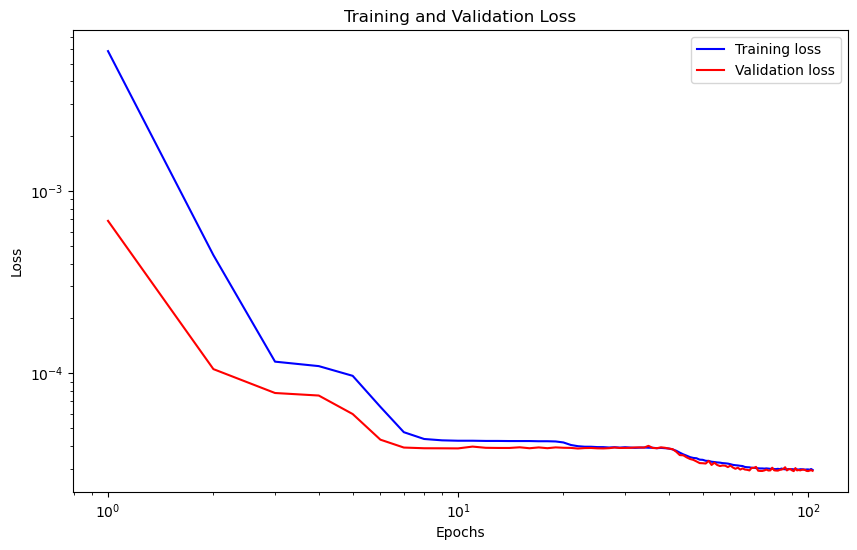

Epoch 1, Train Loss: 0.02235311, Validation Loss: 0.01053953, LR: 1.000e-04,Time_cost:19.441164016723633
Epoch 2, Train Loss: 0.01055507, Validation Loss: 0.00671973, LR: 1.000e-04,Time_cost:44.42738461494446
Epoch 3, Train Loss: 0.00705844, Validation Loss: 0.00400989, LR: 1.000e-04,Time_cost:77.05253028869629
Epoch 4, Train Loss: 0.00349881, Validation Loss: 0.00174379, LR: 1.000e-04,Time_cost:109.41050171852112
Epoch 5, Train Loss: 0.00135791, Validation Loss: 0.00089485, LR: 1.000e-04,Time_cost:135.2741994857788
Epoch 6, Train Loss: 0.00079274, Validation Loss: 0.00074444, LR: 1.000e-04,Time_cost:165.36209058761597
Epoch 7, Train Loss: 0.00069507, Validation Loss: 0.00070147, LR: 1.000e-04,Time_cost:195.78517293930054
Epoch 8, Train Loss: 0.00065495, Validation Loss: 0.00065593, LR: 1.000e-04,Time_cost:220.67028951644897
Epoch 9, Train Loss: 0.00060828, Validation Loss: 0.00059683, LR: 1.000e-04,Time_cost:253.09459900856018
Epoch 10, Train Loss: 0.00055536, Validation Loss: 0.00053

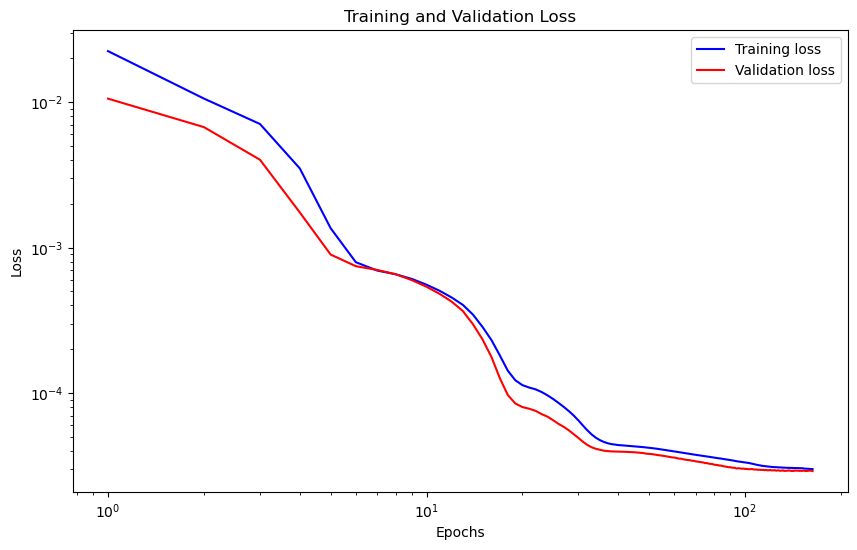

Epoch 1, Train Loss: 0.03125206, Validation Loss: 0.02423105, LR: 3.000e-05,Time_cost:24.322245121002197
Epoch 2, Train Loss: 0.02233393, Validation Loss: 0.01652208, LR: 3.000e-05,Time_cost:48.09683609008789
Epoch 3, Train Loss: 0.01615718, Validation Loss: 0.01147131, LR: 3.000e-05,Time_cost:72.43173289299011
Epoch 4, Train Loss: 0.01257342, Validation Loss: 0.00898153, LR: 3.000e-05,Time_cost:96.37619686126709
Epoch 5, Train Loss: 0.01082282, Validation Loss: 0.00780706, LR: 3.000e-05,Time_cost:125.42050766944885
Epoch 6, Train Loss: 0.00968888, Validation Loss: 0.00695461, LR: 3.000e-05,Time_cost:155.00119400024414
Epoch 7, Train Loss: 0.00868491, Validation Loss: 0.00620773, LR: 3.000e-05,Time_cost:178.4657666683197
Epoch 8, Train Loss: 0.00765742, Validation Loss: 0.00543642, LR: 3.000e-05,Time_cost:202.00098085403442
Epoch 9, Train Loss: 0.00658299, Validation Loss: 0.00464440, LR: 3.000e-05,Time_cost:225.55439615249634
Epoch 10, Train Loss: 0.00549806, Validation Loss: 0.003862

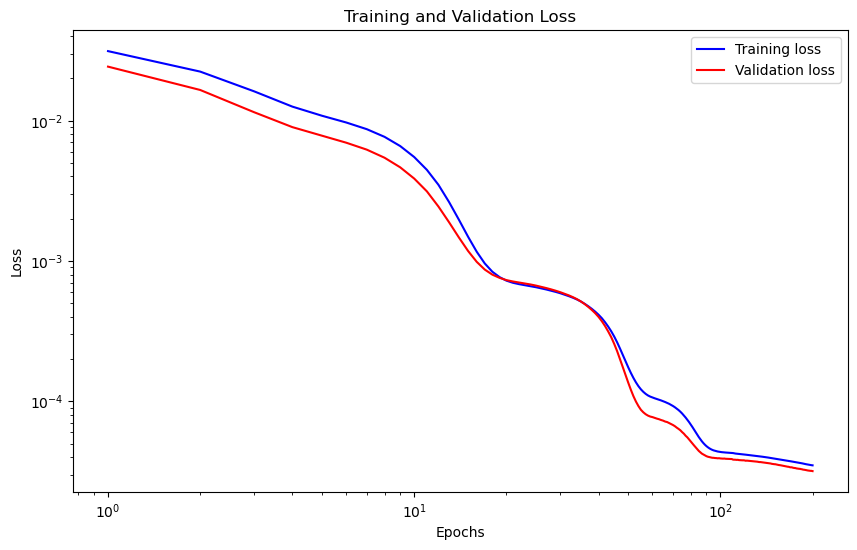

Epoch 1, Train Loss: 0.00595572, Validation Loss: 0.00063167, LR: 1.000e-02,Time_cost:19.852043628692627
Epoch 2, Train Loss: 0.00060436, Validation Loss: 0.00064294, LR: 1.000e-02,Time_cost:43.801480770111084
Epoch 3, Train Loss: 0.00061570, Validation Loss: 0.00063382, LR: 1.000e-02,Time_cost:67.63799452781677
Epoch 4, Train Loss: 0.00060363, Validation Loss: 0.00062068, LR: 1.000e-02,Time_cost:91.638587474823
Epoch 5, Train Loss: 0.00200545, Validation Loss: 0.00063518, LR: 1.000e-02,Time_cost:116.78878426551819
Epoch 6, Train Loss: 0.00059080, Validation Loss: 0.00061467, LR: 1.000e-02,Time_cost:141.05124521255493
Epoch 7, Train Loss: 0.00026211, Validation Loss: 0.00008343, LR: 1.000e-02,Time_cost:165.26119422912598
Epoch 8, Train Loss: 0.00017812, Validation Loss: 0.00008174, LR: 1.000e-02,Time_cost:189.19762229919434
Epoch 9, Train Loss: 0.00011278, Validation Loss: 0.00007708, LR: 1.000e-02,Time_cost:213.4546399116516
Epoch 10, Train Loss: 0.00009201, Validation Loss: 0.0000694

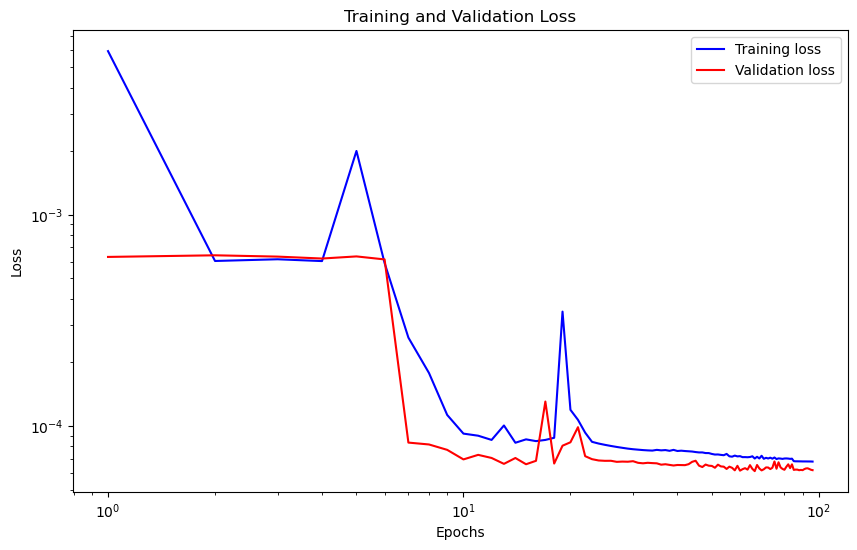

Epoch 1, Train Loss: 0.00225200, Validation Loss: 0.00059578, LR: 1.000e-03,Time_cost:19.860558032989502
Epoch 2, Train Loss: 0.00024255, Validation Loss: 0.00012020, LR: 1.000e-03,Time_cost:43.994089126586914
Epoch 3, Train Loss: 0.00011267, Validation Loss: 0.00007365, LR: 1.000e-03,Time_cost:68.03074622154236
Epoch 4, Train Loss: 0.00009315, Validation Loss: 0.00008157, LR: 1.000e-03,Time_cost:92.10584330558777
Epoch 5, Train Loss: 0.00009009, Validation Loss: 0.00008775, LR: 1.000e-03,Time_cost:116.06860733032227
Epoch 6, Train Loss: 0.00009314, Validation Loss: 0.00007028, LR: 1.000e-03,Time_cost:139.95835137367249
Epoch 7, Train Loss: 0.00008788, Validation Loss: 0.00006645, LR: 1.000e-03,Time_cost:163.85205554962158
Epoch 8, Train Loss: 0.00008480, Validation Loss: 0.00006590, LR: 1.000e-03,Time_cost:187.659569978714
Epoch 9, Train Loss: 0.00008560, Validation Loss: 0.00008408, LR: 1.000e-03,Time_cost:211.56353330612183
Epoch 10, Train Loss: 0.00008289, Validation Loss: 0.000079

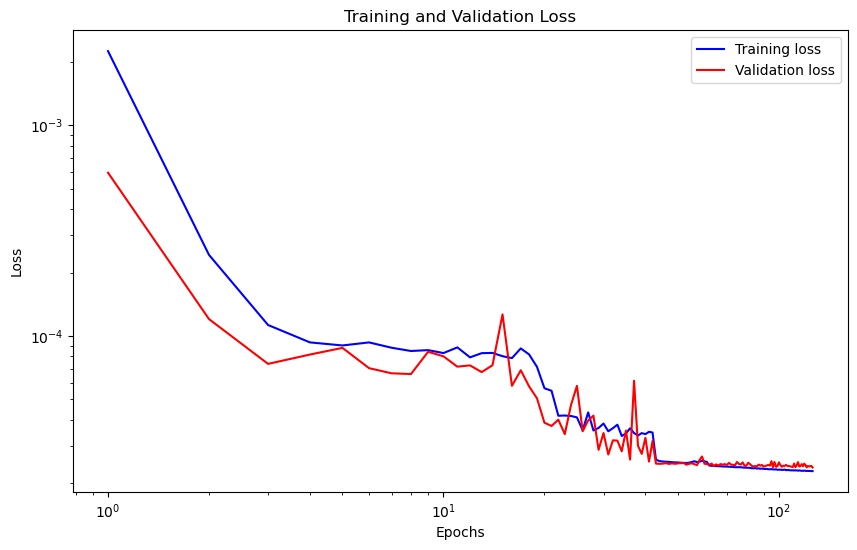

Epoch 1, Train Loss: 0.00809937, Validation Loss: 0.00067434, LR: 1.000e-04,Time_cost:19.813205003738403
Epoch 2, Train Loss: 0.00061955, Validation Loss: 0.00061799, LR: 1.000e-04,Time_cost:43.87469434738159
Epoch 3, Train Loss: 0.00037846, Validation Loss: 0.00008718, LR: 1.000e-04,Time_cost:68.02525353431702
Epoch 4, Train Loss: 0.00011370, Validation Loss: 0.00007874, LR: 1.000e-04,Time_cost:92.13288569450378
Epoch 5, Train Loss: 0.00009339, Validation Loss: 0.00007268, LR: 1.000e-04,Time_cost:116.07908368110657
Epoch 6, Train Loss: 0.00008366, Validation Loss: 0.00007020, LR: 1.000e-04,Time_cost:140.17973732948303
Epoch 7, Train Loss: 0.00008094, Validation Loss: 0.00006753, LR: 1.000e-04,Time_cost:164.24211025238037
Epoch 8, Train Loss: 0.00007908, Validation Loss: 0.00006624, LR: 1.000e-04,Time_cost:188.29615807533264
Epoch 9, Train Loss: 0.00007785, Validation Loss: 0.00006581, LR: 1.000e-04,Time_cost:212.47554469108582
Epoch 10, Train Loss: 0.00007691, Validation Loss: 0.00006

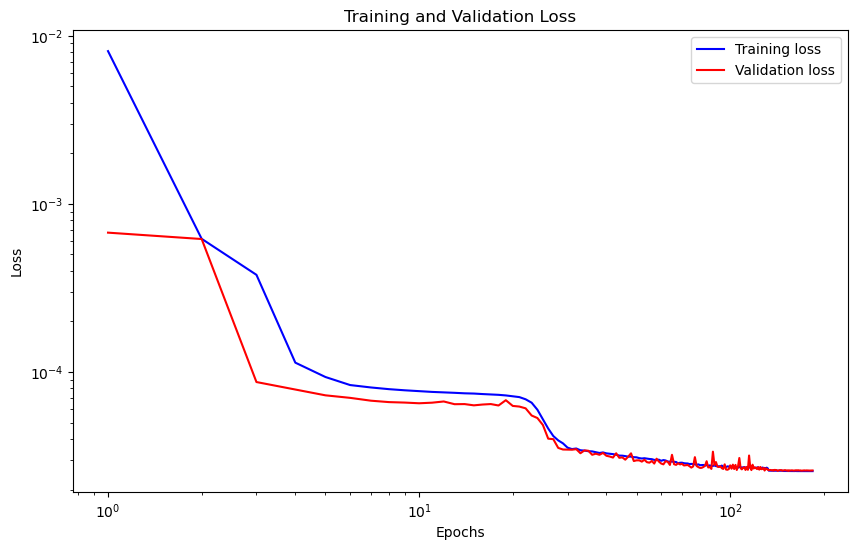

Epoch 1, Train Loss: 0.01774101, Validation Loss: 0.00704615, LR: 3.000e-05,Time_cost:19.93814468383789
Epoch 2, Train Loss: 0.00289072, Validation Loss: 0.00071179, LR: 3.000e-05,Time_cost:43.97468066215515
Epoch 3, Train Loss: 0.00065525, Validation Loss: 0.00065424, LR: 3.000e-05,Time_cost:67.95605540275574
Epoch 4, Train Loss: 0.00061959, Validation Loss: 0.00063601, LR: 3.000e-05,Time_cost:96.17593765258789
Epoch 5, Train Loss: 0.00059692, Validation Loss: 0.00060992, LR: 3.000e-05,Time_cost:124.99389839172363
Epoch 6, Train Loss: 0.00053673, Validation Loss: 0.00044259, LR: 3.000e-05,Time_cost:153.3260040283203
Epoch 7, Train Loss: 0.00021620, Validation Loss: 0.00008636, LR: 3.000e-05,Time_cost:179.55706000328064
Epoch 8, Train Loss: 0.00011576, Validation Loss: 0.00008139, LR: 3.000e-05,Time_cost:203.7405595779419
Epoch 9, Train Loss: 0.00010807, Validation Loss: 0.00007754, LR: 3.000e-05,Time_cost:227.91131377220154
Epoch 10, Train Loss: 0.00010018, Validation Loss: 0.00007401

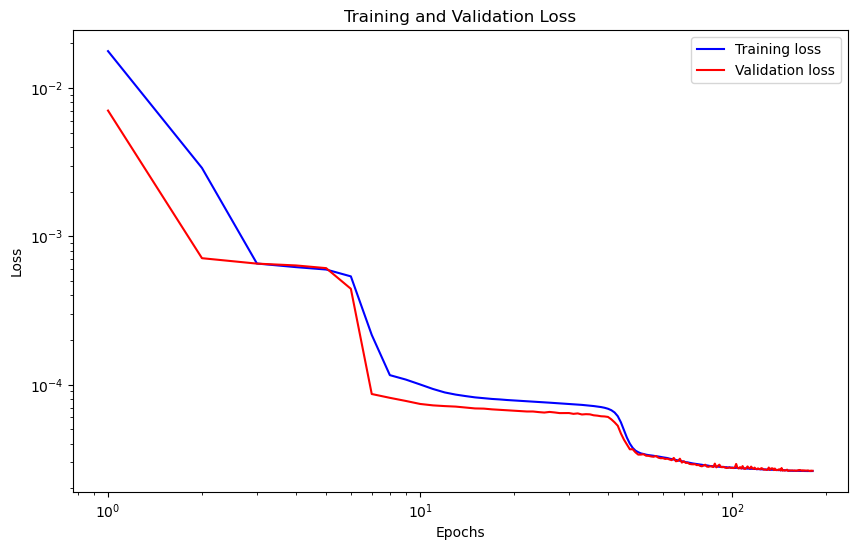

In [14]:
import pickle
import time
#Scan different hyperparameters
TR_spectra,TE_spectra=torch.as_tensor(TR_spectra),torch.as_tensor(TE_spectra)
TR_F,TE_F=torch.as_tensor(TR_F),torch.as_tensor(TE_F)
TR_num=TR_spectra.shape[0]
val_num=int(TR_num/8)
tr_num=TR_num-val_num
TR1_spectra,TR1_F,val1_spectra,val1_F=TR_spectra[:tr_num],TR_F[:tr_num],TR_spectra[tr_num:],TR_F[tr_num:]

seed=42
weight_decay=5e-7
patience_lr=7
factor=0.3
epochs=200
batch_sizes=[2**14]#tr_num,1048576,131072,4096,8192,16384,32768,65536,262144,524288
patience=30
count=105#[31],[3],[16],[8],[4,8],[8,16],[16,32],[16,32,64],[3,3,8,8],[8,16,32,32],[4,8,16,32],[3,3,8,8,16,16],[8,8,16,16,32,32],[16,16,16,32,32,32],[16,16,32,32,64,64],[128,128,64,64,32,32],[32,64],
#[8,16,32],[256,256,128,128,64,64],[64,64,64,32,32,32],[32,32,32,32,32,32],[128,128,64,64],[64,64,32,32],[256,128,64,32],[128,64,32],[64,32,32],
Dsizes=[[64,32],[512,512,256,256,128,128]]#,
lrs=[1e-2,1e-3,1e-4,3e-5]
for Dsize in Dsizes:
    for batch_size in batch_sizes:
        hyperparameterss=[]
        best_results=[]
        tr_historys,val_historys=[],[]
        for lr in lrs:
            if lr in [1e-2] and Dsize==[64,32]:
                continue
            lr=lr
            gc.collect()
            torch.cuda.empty_cache()
            if seed!=None:
                np.random.seed(seed)
                random.seed(seed)
                torch.manual_seed(seed)
                torch.cuda.manual_seed(seed)
                torch.cuda.manual_seed_all(seed)

            train_dataset = TensorDataset(TR1_F,TR1_spectra)
            val_dataset = TensorDataset(val1_F,val1_spectra)
            test_dataset = TensorDataset(TE_F,TE_spectra)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=2**14, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=2**14, shuffle=False)
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            loss_f = lambda _x, x: torch.square(torch.subtract(_x, x)).mean() 
            # Hidden dimension (~number of parameters in autoencoder model)

            autoencoder = AutoEncoder(
                activ=nn.ReLU(),
                z_dim=3, 
               Dsize=Dsize
            )
            autoencoder = autoencoder.to(device)
           
            best_model = copy.deepcopy(autoencoder)
            optimizer = optim.Adam(autoencoder.parameters(),lr=lr,weight_decay=weight_decay)
            if isinstance(patience_lr, list):
                scheduler=get_piecewise_scheduler(optimizer,patience_lr,factor)
            else:
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=factor,patience=patience_lr,threshold=1e-3)


            losses = []
            # Training loop with early stopping and learning rate scheduling
            best_loss = float('inf')
            best_tr_loss= float('inf')
            epochs_no_improve = 0

            global_train_loss = []
            global_val_loss = []
            test_losses=[]
            time_cost=[]
            
            #begin truaining
            start_time = time.time()
            for epoch in range(epochs):
                autoencoder.train()
                train_loss = 0.
                for xtrb, ytrb in train_loader:
                    xtrb = xtrb.to(device)
                    ytrb=ytrb.to(device)
                    _x= autoencoder.decoder(xtrb)
                    # Compute reconstruction loss of autoencoder encoding, then decoding back to data space
                    rec_loss = loss_f(_x, ytrb)

                    optimizer.zero_grad()
                    rec_loss.backward()
                    optimizer.step()
                    train_loss += rec_loss.item()

                train_loss /= len(train_loader)
                global_train_loss.append(train_loss)

                autoencoder.eval()
                val_loss = 0.
                
                with torch.no_grad():
                    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                    for xvalb,yvalb in val_loader:
                        xvalb = xvalb.to(device)
                        yvalb = yvalb.to(device)
                        _x= autoencoder.decoder(xvalb)
                    # Compute reconstruction loss of autoencoder encoding, then decoding back to data space
                        rec_loss = loss_f(_x, yvalb)
                        val_loss += rec_loss.item()

                    val_loss /= len(val_loader)
                    if isinstance(patience_lr,list):
                        scheduler.step(epoch)
                    else:
                        scheduler.step(train_loss)
                        lr_ = optimizer.param_groups[0]['lr']
                        global_val_loss.append(val_loss)
                    end_time=time.time()
                    time_cost.append(end_time-start_time)

                    te_loss=0.
                    for xvalb,yvalb in test_loader:
                        xvalb = xvalb.to(device)
                        yvalb = yvalb.to(device)
                        _x= best_model.decoder(xvalb)
                    # Compute reconstruction loss of autoencoder encoding, then decoding back to data space
                        rec_loss = loss_f(_x, yvalb)
                        te_loss += rec_loss.item()
                    te_loss /= len(test_loader)  
                    test_losses.append(te_loss)
                    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}, LR: {lr_:.3e},Time_cost:{end_time-start_time}")

                    # Early stopping and learning rate scheduling
                    if val_loss+1e-7 < best_loss:
                        best_loss = val_loss
                        best_model = autoencoder
                        epochs_no_improve = 0
                    elif train_loss>best_tr_loss+0.15:
                        epochs_no_improve = 0
                    else:
                        epochs_no_improve += 1
                        best_tr_loss=train_loss
                    if epochs_no_improve >= patience and epoch>=5:
                        print("Early stopping triggered")
                        break


            tr_losses,val_losses=global_train_loss,global_val_loss

            #compute the index coresponding to the best validation loss and validation metric
            min_index=val_losses.index(min(val_losses))
            min_index_tr=tr_losses.index(min(tr_losses))

            best_result=[tr_losses[min_index],val_losses[min_index],test_losses[min_index],time_cost[min_index],sum(p.numel() for p in best_model.parameters()),min_index,min_index_tr]
            param_names = ['Dsize','lr','batch_size']

            hyperparameters=[Dsize,lr,batch_size]
            hyperparameters = dict(zip(param_names, hyperparameters))
            print('hypeparameters: ', hyperparameters)
            print('best results:',best_result)
            hyperparameterss.append(hyperparameters)
            best_results.append(best_result)
            tr_historys.append(tr_losses)
            val_historys.append(val_losses)

            total_epoch = range(1, len(tr_losses) + 1)
            plt.figure(figsize=(10, 6))
            plt.loglog(total_epoch , tr_losses, 'b', label='Training loss')
            plt.loglog(total_epoch , val_losses, 'r', label='Validation loss')
            plt.title(f'Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            # plt.ylim([-2.,+1.])
            plt.legend()
            plt.show()
 
            gc.collect()
            torch.cuda.empty_cache()

            with open(f'datas/RGBMLP_14_hyper_{count}.pickle','wb') as f:
                pickle.dump(hyperparameterss,f)
            with open(f'datas/RGBMLP_14_best_{count}.pickle','wb') as f:
                pickle.dump(best_results,f)
            with open(f'datas/RGBMLP_14_tr_{count}.pickle','wb') as f:
                pickle.dump(tr_historys,f)
            with open(f'datas/RGBMLP_14_val_{count}.pickle','wb') as f:
                pickle.dump(val_historys,f)
            count+=1

### Physics-Informed Deep Learning

In the previous sections, we explored using a fully connected neural network (MLP) and principal component analysis (PCA) to learn the mapping between RGB values and their corresponding hyperspectral representations. While these approaches can learn complex relationships, they do not explicitly incorporate the physical constraints of the imaging process or prior knowledge about the hyperspectral data. As such, **there is a risk that the network will predict unphysical results if inputs diverge too much from the training set**.

Physics-informed deep learning offers a powerful framework to integrate prior knowledge and physical constraints into the learning process. By incorporating this additional information, we can improve the accuracy and reliability of hyperspectral reconstruction from RGB measurements. In this section, we will briefly introduce you to two state-of-the-art approaches to physics-informed deep learning for hyperspectral reconstruction: Physics-Informed Neural Networks (PINNs) and neural network regularization.

#### Physics-Informed Neural Networks (PINNs)

PINNs incorporate physical constraints directly into the neural network architecture and loss function. In the context of hyperspectral reconstruction, we can leverage the forward RGB projection model as an additional constraint to ensure that the reconstructed hyperspectral data is consistent with the observed RGB values.

Recall that forward RGB projection can be expressed as:
$$
F = Q \cdot S \cdot \Delta \lambda
$$
where $Q$ is the matrix representing the camera's quantum efficiencies, $S$ is the hyperspectral data matrix, and $\Delta \lambda$ is the width of each spectral band.

The PINN loss function consists of two terms: a reconstruction loss $\mathcal{L}_{recon}$ that minimizes the difference between the reconstructed hyperspectral data and the ground truth, and an additional RGB consistency loss $\mathcal{L}_{rgb}$ that penalizes the discrepancy between the projected RGB values of the reconstructed data and the original RGB measurements.

---
<details>
<summary>More details about PINNs</summary>

Recall that the forward RGB projection can be expressed as:

$$
F = Q \cdot S \cdot \Delta \lambda
$$

where $Q$ is the matrix representing the camera's quantum efficiencies, $S$ is the hyperspectral data matrix, and $\Delta \lambda$ is the width of each spectral band.

To incorporate this physical constraint into the neural network, we can modify the loss function to include a term that penalizes the difference between the projected RGB values of the reconstructed hyperspectral data and the original RGB measurements. The modified loss function can be written as:

$$
\mathcal{L} = \mathcal{L}_{recon} + \alpha \mathcal{L}_{rgb}
$$

where $\mathcal{L}_{recon}$ is the reconstruction loss (e.g., mean squared error) between the reconstructed hyperspectral data and the ground truth, $\mathcal{L}_{rgb}$ is the RGB consistency loss, and $\alpha$ is a hyperparameter that controls the balance between the two loss terms.

The RGB consistency loss $\mathcal{L}_{rgb}$ can be computed as:

$$
\mathcal{L}_{rgb} = \frac{1}{N} \sum_{i=1}^{N} \| F_i - \hat{F}_i \|^2
$$

where $N$ is the number of samples, $F_i$ is the original RGB measurement for the $i$-th sample, and $\hat{F}_i$ is the projected RGB values obtained from the reconstructed hyperspectral data $\hat{S}_i$ using the forward RGB projection:

$$
\hat{F}_i = Q \cdot \hat{S}_i \cdot \Delta \lambda
$$

By minimizing the modified loss function during training, the neural network learns to reconstruct hyperspectral data that not only resembles the ground truth but also satisfies the physical constraint of being consistent with the observed RGB measurements.

The training process for the PINN-based hyperspectral reconstruction can be summarized as follows:
1. Pass the RGB values through the neural network to obtain the reconstructed hyperspectral data $\hat{S}$.
2. Compute the reconstruction loss $\mathcal{L}_{recon}$ between $\hat{S}$ and the ground truth hyperspectral data.
3. Project the reconstructed hyperspectral data $\hat{S}$ to the RGB space using the forward RGB projection to obtain $\hat{F}$.
4. Compute the RGB consistency loss $\mathcal{L}_{rgb}$ between $\hat{F}$ and the original RGB measurements.
5. Calculate the total loss $\mathcal{L}$ as a weighted sum of the reconstruction loss and the RGB consistency loss.
6. Backpropagate the gradients and update the network parameters to minimize the total loss.

By incorporating the physical constraint through the RGB consistency loss, the PINN approach encourages the neural network to learn a physically meaningful mapping between RGB values and hyperspectral data. This can lead to improved reconstruction quality and better generalization to unseen data.
</details>

---

#### Neural Network Regularization

An alternative approach to physics-informed deep learning is to use neural networks for regularization in a least squares formulation. This method, employed in techniques such as plug-and-play and deep algorithm unrolling, focuses on learning an appropriate regularization term in the non-sparse domain.
The goal is to estimate the residual error $\epsilon$ between the least squares estimate $\hat{x}$ and the true solution $x_{true}$. A neural network $\mathcal{N}$ is trained to approximate the residual error:

$$
\mathcal{N}(\hat{x}) \approx \epsilon(\hat{x}) = (x_{true} - \hat{x})
$$

The updated solution estimate is obtained by adding the learned residual to the least squares estimate:
$$
\hat{x}' = \hat{x} + \mathcal{N}(\hat{x})
$$

This deep learning estimate of the solution is used for regularization in the least squares problem, where we search for solutions that minimize the sum of the data fidelity term and a regularization term based on the proximity to the neural network estimate.

---
<details>
<summary>More details about NN regularization</summary>

Instead of directly learning the mapping between RGB values and hyperspectral data, this method focuses on learning an appropriate regularization term in the non-sparse domain $x$. The goal is to estimate the residual error $\epsilon$ between the least squares estimate $\hat{x}$ and the true solution $x_{true}$.

Given a set of training data, a neural network $\mathcal{N}$ is trained to approximate the residual error:

$$
\mathcal{N}(\hat{x}) \approx \epsilon(\hat{x}) = (x_{true} - \hat{x})
$$

The updated solution estimate is then obtained by adding the learned residual to the least squares estimate:

$$
\hat{x}' = \hat{x} + \mathcal{N}(\hat{x})
$$

This deep learning estimate of the solution can be used for regularization in the least squares problem. We search for solutions that minimize the sum of the data fidelity term and a regularization term based on the proximity to the neural network estimate:

$$
\hat{x}'' = \underset{x}{\mbox{argmin}} \{\|Ax - y\|^2 + \lambda \|\hat{x}' - x\|^2\}
$$

where $A$ is the projection matrix, $y$ is the observed RGB data, and $\lambda$ is a hyperparameter controlling the strength of the regularization.

Both the residual update step and the regularized least squares problem can be applied recursively to iteratively improve the solution estimate. There are two common approaches:

1. Plug-and-Play: In this method, the same neural network $\mathcal{N}$ is used at each iteration to estimate the residual error and update the solution.

2. Deep Algorithm Unrolling: This technique involves training a custom neural network $\mathcal{N}_i$ for each iteration $i$. The networks are trained to optimize the reconstruction quality at each unrolled iteration of the algorithm.

The training process for these methods involves the following steps:
1. Generate a set of training data consisting of RGB measurements and their corresponding ground truth hyperspectral data.
2. Initialize the solution estimate $\hat{x}$ using a least squares approach or any other suitable method.
3. Train the neural network(s) $\mathcal{N}$ (or $\mathcal{N}_i$ for deep unrolling) to approximate the residual error between the current estimate and the ground truth.
4. Update the solution estimate using the learned residual and/or solve the regularized least squares problem.
5. Repeat steps 3-4 for a fixed number of iterations or until a convergence criterion is met.

The use of neural networks for regularization in the least squares formulation offers several advantages. It allows for faster convergence compared to traditional iterative optimization methods and can effectively capture complex prior information about the hyperspectral data. Moreover, by operating in the non-sparse domain, this approach can potentially handle a wider range of hyperspectral reconstruction scenarios.
</details>

---

Both the PINN approach and the neural network regularization approach have their strengths and limitations. PINNs provide a principled way to incorporate physical constraints directly into the neural network, while neural network regularization allows for faster convergence and can effectively capture complex prior information about the hyperspectral data.

---
<details>
<summary>Extra Task for Bonus Points</summary>

> - **Task 2.8** Implement a physics-informed deep learning model for hyperspectral reconstruction using either the PINN approach or the neural network regularization approach (or both, if time permits). Compare the reconstruction quality, convergence speed, and interpretability with the standard MLP and PCA-based methods. Discuss the benefits and limitations of incorporating physical constraints and prior knowledge into the learning process.
</details>

---

By exploring physics-informed deep learning techniques, we can leverage the power of deep learning while ensuring that the reconstructed hyperspectral data is consistent with the underlying physical principles and observed measurements. These approaches provide a comprehensive framework for tackling the challenging problem of snapshot hyperspectral imaging and offer valuable insights into the integration of domain knowledge and data-driven learning.

---
# 3. Compressed Sensing for Hyperspectral Imaging
---

So far, our analysis has focused on the idea that scenes may be spectrally sparse. However, many scenes can also be compressed spatially. For instance, the JPEG format compresses images using a sparse discrete cosine transform (DCT) basis. This spatial sparsity can be exploited alongside spectral sparsity to further improve the efficiency of hyperspectral imaging.

Compressed sensing is a powerful framework that allows for the acquisition and reconstruction of signals using far fewer measurements than traditional methods. It relies on the key insight that many natural signals are sparse or compressible in some basis or dictionary. By designing measurement systems that capture the essential information in the sparse domain, compressed sensing enables the recovery of high-dimensional signals from low-dimensional measurements.

The foundational work on compressed sensing was introduced by Emmanuel Candès, Justin Romberg, Terence Tao, and David Donoho in 2006. In their seminal papers, they showed that if a signal is sparse or compressible in some basis, it can be accurately reconstructed from a small number of linear measurements, provided that the measurement matrix satisfies certain properties such as the restricted isometry property (RIP) or incoherence.

The application of compressed sensing to hyperspectral imaging has gained significant attention in recent years. By exploiting both spatial and spectral sparsity, compressed sensing techniques can greatly reduce the number of measurements required to capture a hyperspectral data cube. This not only leads to faster acquisition times but also enables the development of more compact and cost-effective hyperspectral imaging systems.

In the context of snapshot hyperspectral imaging, compressed sensing plays a crucial role in enabling the reconstruction of the 3D hyperspectral data cube from 2D measurements captured by the sensor. By carefully designing the optical system and the measurement process, such as using coded apertures or dispersive elements, the essential information in the hyperspectral data cube can be encoded into the 2D measurements. Reconstruction algorithms based on sparse signal recovery techniques, such as basis pursuit or greedy methods, can then be employed to recover the full hyperspectral data cube from the compressed measurements.

So today we will go through a bit of the theory of **compressed sensing** - the theory of capturing a signal with less measurements than typically required by Nyquist. Then we will move to the specific case of **snapshot compressive imaging** - capturing 3D data on a 2D sensor.


> **Further Reading**:
- The original paper by Terence Tao and Emmanuel Candès, *Near-Optimal Signal Recovery From Random Projections: Universal Encoding Strategies?* (2006), provides a comprehensive introduction to compressed sensing and its theoretical foundations. The paper establishes the conditions under which sparse signals can be accurately reconstructed from random linear measurements and introduces the concept of restricted isometry property (RIP). It serves as a foundational work in the field of compressed sensing and has inspired numerous applications and extensions. ([Link](https://ieeexplore.ieee.org/document/4016283))
- The tutorial by Arce et al. *Compressive coded aperture spectral imaging: An introduction* surveys the concept of coded aperture snapshot spectral imagers ([Link](https://www.eecis.udel.edu/~arce/files/Publications/ArceMagazine06678264-2.pdf))



### Compressed Sensing

To get a very basic intuition, lets start with a very simplified example. Lets say there is some spectra, $\vec{x}$, that we would like to capture, containing 7 spectral bands from 400-700nm. However, our detector (a single camera pixel), can only measure the integrated spectra. Before the camera captures the signal, we can apply an operation to it... for example, we can apply a filter which will only let through certain wavelengths. We can represent one capture as the dot product of a measurement vector, $\vec{\phi}$, with $\vec{x}$;

\begin{equation}
    y = \vec{\phi}\cdot\vec{x}.
\end{equation}

For example, the application of a narrow bandpass filter would yield the measurement of one band of the spectra;

\begin{equation}
   y = \begin{bmatrix}0\\ 1 \\0 \\0 \\0\\0\\0\end{bmatrix}\cdot\begin{bmatrix}x_{400}\\ x_{450} \\x_{500} \\x_{550} \\x_{600}\\x_{650} \\x_{700}\end{bmatrix} =  x_{450}.
\end{equation}

We can represent multiple measurements by using a matrix $\mathbf{\Phi}$. For example, two measurements, each with a different filter;

\begin{align}
   \vec{y} &= \mathbf{\Phi}\vec{x}\\
   &=\begin{bmatrix}0& 1 &0 &0 &0&0&0\\0& 0 &1 &0 &0&0&0\end{bmatrix}\begin{bmatrix}x_{400}\\ x_{450} \\x_{500} \\x_{550} \\x_{600}\\x_{650} \\x_{700}\end{bmatrix} = \begin{bmatrix} x_{450} \\x_{500} \end{bmatrix}.
\end{align}

> - **Task 3.1** So the first question is, how many measurements does one require to capture the full signal $\vec{x}$?
-  **Task 3.2** Now some nice PhD student gives you the additional information that they know that the spectra is actually mainly zeros, and only one element of $\vec{x}$ is non-zero (it is very sparse). How many measurements do we need to fully capture $\vec{x}$ now? Design an example measurement matrix $\mathbf{\Phi}$.




In [17]:
# for Task 3.2, create the sparse vector x.
x = np.zeros(7)
sparse_idx = np.random.randint(7)
sparse_value = np.random.rand()
x[sparse_idx] = sparse_value

# your task is to create Phi, so that it can fully capture x, with a minimal number of measurements (rows)
Phi = np.ones((1,7))
Phi@x==sparse_value

array([ True])


**So in this basic example, we see how we can exploit the sparsity in a signal to design measurement vectors to capture it in a more efficient way.**

Now, practical situations aren't this nice. As you saw in the last session, real world signals contain redundancy, but usually this sparsity is in a different basis (often in a basis we dont even know). **Compressed Sensing** describes the framework for 1) Optimizing the measurement vectors, and  2) Reconstructing the signal.

### Measurement Process

So we have some real-world signal, $x$, can be described by $x = \mathbf{\Psi} f$; where $f$ is a sparse representation containing mainly non-zeros, and $\mathbf{\Psi}$ is the sparse basis matrix (eg. the Fourier basis). We wish to capture it in as few measurements as possible. We represent a collection of measurements using a matrix $\mathbf{\Phi}$. A single measurement can then be wrote in terms of the sparse representation of the signal,
\begin{equation}
    y_i = \Phi_i x  = (\Phi_i \mathbf{\Psi}) f,
\end{equation}

where $(\Phi_i \mathbf{\Psi})$ describes the effective sampling vector on the sparse vector $f$.

There are two intuitive conditions that this effective sampling vector should fulfil:
- Firstly, in order to reliably recover the signal we must sample the whole sparse signal. Otherwise, if the non-zero elements are outside our sampling region, they are invisible. Thus $(\Phi_i \mathbf{\Psi})$ should be dense.
- Secondly, we wish for each measurement to be uncorrelated with the other measurements (we need to be efficient... don't measure the same information twice).

To address the first of these criteria, consider the absolute value of the correlation between a row of the sampling matrix, and a row of the sparse basis;
\begin{equation}
    \textrm{Corr}(\Phi_i,\Psi_j) = \sqrt{n}  \left|\Phi_i \cdot\Psi_j\right|.
\end{equation}

By definition, a single row of the sparse basis is sampling a single element of the sparse signal. So then, we wish to minimize the absolute correlation of our measurement vector with all the rows of the sparse basis, so that all measurements sample the whole sparse vector! This statement can be expressed by minimizing the *Coherence* between the sampling matrix and the sparse basis, which is defined as
\begin{equation}
    C(\Psi,\Phi) = \sqrt{n} \underset{1\leq i,j \leq n}{\textrm{max}} \left|\Phi_i \cdot\Psi_j\right|.
\end{equation}

As we would also like all the measurements to be uncorrelated, we also minimize a similar quantity between rows of the measurement basis,

\begin{equation}
    \tilde{C}(\Phi) = \sqrt{n} \:\underset{i\neq j}{\textrm{max}} \left|\Phi_i \cdot\Phi_j\right|.
\end{equation}
It is clear that this quantity is minimized by an orthonormal basis.

> - **Task 3.3** Below is some code to make the sparse basis for the discrete cosine basis (DCT). Calculate the coherence of this basis with a number of different measurement bases (pixel basis, discrete cosine basis, random basis) and visualise the effective sparse sampling basis $(\Phi \Psi)$. Discuss which of these bases are suitable to perform compressed sensing, and which are not.



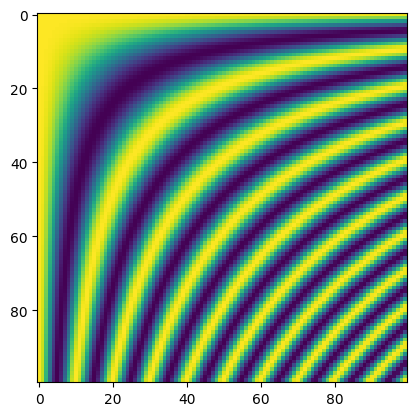

In [ ]:
def create_dct_matrix(domain):
    n = len(domain)
    dct_matrix = torch.zeros((n, n))
    for j in range(n):
        dct_matrix[j] = (1/n)**0.5 * torch.cos((torch.pi * (j + 1/2) * domain) / (n))
    return dct_matrix

domain = torch.linspace(0,20,100) #keep this constant

dct = create_dct_matrix(domain)
plt.imshow(dct)



### Reconstruction
Okay, so now we have made a measurement using our efficient measurement basis - we have obtained $y$. How do we go from our low dimensional measurement, to a high dimensional signal? Compressed sensing deals with an under-determined system of equations:  $y=(\Phi \Psi) f$. There are many possible $f$ that satisfy this equation, but we are looking for the most sparse one. The number of non-zero elements in $f$ can be expressed as the $||_0$ norm. Thus, the equation we wish to solve is,
\begin{equation}
    \underset{\tilde{f}}{\textrm{min}}|\tilde{f}|_{0} \:\:\: \textrm{subject to}\:\:\: y = (\Phi\Psi) \tilde{f}.
\end{equation}

Unfortunately, this is a hard equation to solve numerically, due to the discontinuous nature of the $||_0$ norm.  However, it has been showing that minimizing the $||_1$ norm can often have the same effect, so the equation that is actually solved is,
\begin{equation}
    \underset{\tilde{f}}{\textrm{min}}|\tilde{f}|_{1} \:\:\: \textrm{subject to}\:\:\: y = (\Phi\Psi) \tilde{f}.
\end{equation}

In case you are interested in why minimizing $||_{1}$ also minimizes $||_{0}$, see the *Further Reading* section at the end of the notebook. A popular algorithm to solve the above equation is [LASSO](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

<details>
<summary>LASSO (Least Absolute Shrinkage and Selection Operator)</summary>
LASSO is a regression analysis method that performs both variable selection and regularization to enhance the prediction accuracy and interpretability of the resulting statistical model. It was introduced by Robert Tibshirani in 1996 as a powerful tool for sparse signal recovery and feature selection.
The LASSO method is particularly useful in scenarios where the number of predictor variables (features) is large compared to the number of observations, or when there is a need to identify the most relevant variables that contribute significantly to the response variable.
Given a linear regression problem with predictor variables $X_1, X_2, \ldots, X_p$ and a response variable $Y$, the LASSO objective function is defined as:

$
  \underset{\beta}{\text{minimize}} \left\{ \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \lambda \sum_{j=1}^{p} |\beta_j| \right\}
$
where:

$n$ is the number of observations
$y_i$ is the response variable for the $i$-th observation
$x_{ij}$ is the value of the $j$-th predictor variable for the $i$-th observation
$\beta_0$ is the intercept term
$\beta_j$ is the coefficient for the $j$-th predictor variable
$\lambda$ is the regularization parameter that controls the strength of the L1 penalty

The LASSO objective function consists of two terms:

The first term is the ordinary least squares (OLS) loss function, which measures the sum of squared residuals between the predicted values and the actual values of the response variable.
The second term is the L1 penalty, which is the sum of the absolute values of the coefficients multiplied by the regularization parameter $\lambda$. This term encourages sparsity in the coefficient estimates, effectively shrinking some coefficients to exactly zero.

The regularization parameter $\lambda$ plays a crucial role in the LASSO method. As $\lambda$ increases, more coefficients are shrunk towards zero, resulting in a sparser model. Conversely, when $\lambda = 0$, the LASSO reduces to the ordinary least squares regression.
The LASSO has several advantages:

It performs automatic variable selection by setting some coefficients to exactly zero, effectively identifying the most relevant predictor variables.
It produces sparse models, which enhances model interpretability and reduces overfitting.
It can handle high-dimensional data, where the number of predictor variables is much larger than the number of observations.

However, the LASSO also has some limitations:

If there are highly correlated predictor variables, the LASSO tends to arbitrarily select one of them and set the coefficients of the others to zero.
It may not perform well when the number of predictor variables is much larger than the number of observations (p >> n) and the predictor variables are not sparse.

To overcome these limitations, variations of the LASSO, such as the Elastic Net and the Adaptive LASSO, have been proposed. These methods combine the L1 and L2 penalties or assign different weights to the penalty terms based on the coefficient estimates.
In the context of compressed sensing and sparse signal recovery, the LASSO is used to reconstruct sparse signals from a limited number of measurements. By minimizing the L1 norm of the coefficients, the LASSO promotes sparsity in the reconstructed signal, effectively identifying the non-zero components while setting the rest to zero.
The LASSO optimization problem can be solved using various algorithms, such as coordinate descent, least angle regression (LARS), or proximal gradient methods. Efficient implementations of the LASSO are available in many statistical software packages and programming languages, making it a popular choice for sparse signal recovery and feature selection tasks.
</details>

> - **Task 3.4** Below is a signal, $x$, of length 100, that is sparse in the DCT basis (keep the domain from 0-20). First design a measurement basis with $\leq 20$ measurements based on the above discussion, and perform a measurement of the signal to get $y$. Then read and understand LASSO, before implementing it to recover the sparse components (you can use the sklearn library).




In [ ]:
!gdown --id 1HmcGa0w8AeWzPmYE-ZeJBLYvhMXByXJR

# x is the signal that is sparse in DCT basis.
x = torch.from_numpy(np.load('/content/praktikum_trial_data.npy'))


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HmcGa0w8AeWzPmYE-ZeJBLYvhMXByXJR
To: /content/praktikum_trial_data.npy
100% 528/528 [00:00<00:00, 1.19MB/s]


### Snapshot Compressive Imaging
In single-shot hyperspectral imaging, the data that we would like to capture, $x$, has a shape of $(n_i \times n_j \times n_\lambda)$. However, our measurements by the 2D detector, $y$, has a shape of $(n_i \times n_j)$. Thus, we will apply the compressed sensing arguments in order to perform the capturing of $x$. A key difference from the situation described in section 1, is that in the most general case we do not actually know what basis our signal is sparse in. As we saw in task 3, the random measurement basis proves to have low coherence with any basis. Thus in order to satisfy the low coherence criterion, we design a measurement system, to perform (approximately) random sampling of the 3d cube onto the 2d sensor.  

This is done with an optical setup named CASSI (coded aperture snapshot spectral imaging). We first use a random mask to achieve random sampling spatially. Then we disperse, so that we approximate spatio-spectral random sampling. The signal is captured (integrated spectrally) on a monochromatic camera, resulting in the 2d image the 'coded shot'.


In [ ]:
from IPython.display import HTML

iframe = """
<iframe src="https://drive.google.com/file/d/1SQ3G8b4acfSKgvS03cNM7xaNOMG5640y/preview" width="640" height="480" allow="autoplay"></iframe>
"""
HTML(iframe)


Below you find simple functions to apply the random mask and to disperse the cube, which can be used to (very simply) simulate the CASSI process.


In [ ]:
def apply_mask(cube, mask=None):
    '''
    Apply a random mask to the cube.

    If we have a static mask (the same random mask for every cube) then we give
    it to the function. If not, the function generates a new random mask each
    time.
    '''

    bs, nc, nx, ny = cube.shape

    if mask is None:
      mask = torch.randint(2, (nx,ny))[None,None].tile(1,nc,1,1)

    return cube*mask


def disperse(cube):
    '''
    Disperse a cube by 1 pixel per wavelength.
    '''
    bs, nc, nx, ny = cube.shape
    dispersed_cube = torch.zeros(bs, nc, nx, ny+(nc-1))

    for i in range(cube.shape[1]):
        dispersed_cube[:, i, :, i:i+ny] = cube[:, i, :, :]

    return dispersed_cube

> - **Task 3.5**  Use the above functions to create a new function that can simulate the CASSI process; ie generate a coded shot from a 3d cube. Visualize the coded shot.

As mentioned, typically in Snapshot Compressive Imaging, we do not know the sparse basis of our signal. For the reconstruction, we use deep neural network approaches.



> - **Task 3.6**  Your task is to now train a neural network to reconstruct the 3d hypercubes from 2d coded shots. You may use an architecture of your choice (the UNet architecture is well suited to this), and can use the code blocks below to set up the training. In the below code, the y data is just formed by integrating the cube. You will have to replace this with your CASSI-simulation function. Visualise the final predicted cubes, and give the PSNR metric.

#### *Hint*
*You may find it easier to reconstruct the dispersed form of hypercubes, as this allows for the same spatial dimensions of x and y.*

In [ ]:
# load data
data = torch.from_numpy(np.load('/content/icvl_downsampled.npy')).permute(0,3,1,2)#.to('cuda')
print(data_icvl.shape)

data = data[torch.randperm(len(data))] #randomly shuffle data


# split into train, val, test
no_samples = len(data)
train_samples = torch.arange(int(no_samples*0.7))
val_samples = torch.arange(int(no_samples*0.7),int(no_samples*0.9))
test_samples = torch.arange(int(no_samples*0.9),no_samples)

train_samples = train_samples[torch.randperm(len(train_samples))]
val_samples = val_samples[torch.randperm(len(val_samples))]
test_samples = test_samples[torch.randperm(len(test_samples))]

bs = 8

train_batches = torch.split(train_samples,bs)
val_batches = torch.split(val_samples,bs)
test_batches = torch.split(test_samples,bs)

torch.Size([136, 31, 174, 162])


In [ ]:
model = torch.nn.Sequential(torch.nn.Conv2d(1, 31, kernel_size = 3, padding=1)) #replace with your model.

# set up optimizer and loss criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

n_epochs = 30   # number of epochs to run
history = {'train_loss': [], 'val_loss': []}

In [ ]:
for epoch in range( n_epochs):

    #train on the train set
    accum_train_loss = 0
    model.train()
    for batch in train_batches:

        optimizer.zero_grad()
        xtrain = data[batch] #cubes
        ytrain = xtrain.sum(1).unsqueeze(1) # replace this with your cassi measurement

        pred = model(ytrain) #take the coded shot, and predict the cube.

        loss = loss_fn(pred, xtrain)

        loss.backward() #back propagate
        optimizer.step() #perform parameter update.
        accum_train_loss += loss.data.item()


    #evaluate on the validation set
    accum_val_loss = 0
    model.eval()
    for batch in val_batches:

        xval = data[batch] #cubes
        yval = xval.sum(1).unsqueeze(1) # replace this with your cassi measurement

        pred = model(yval)

        loss = loss_fn(pred, xval)

        accum_val_loss += loss.data.item()

    train_loss = accum_train_loss/len(train_batches)
    val_loss = accum_val_loss/len(val_batches)

    print(f'Epoch {epoch}/{n_epochs}:, train loss: {train_loss:5.5g},  val_mean_loss: {val_loss:5.5g},',end='\r')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    #at end of epoch we can reshuffle train and val sets.
    train_samples = train_samples[torch.randperm(len(train_samples))]
    val_samples = val_samples[torch.randperm(len(val_samples))]
    train_batches = torch.split(train_samples,bs)
    val_batches = torch.split(val_samples,bs)


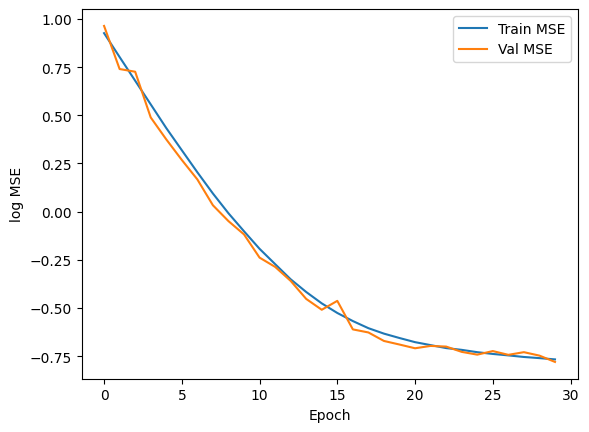

In [ ]:
plt.plot(np.log10(history['train_loss'])); plt.xlabel('Epoch'); plt.ylabel('log MSE')
plt.plot(np.log10(history['val_loss']))
plt.legend(('Train MSE', 'Val MSE'))


## Further Reading

### Why does miniziming the $\ell_1$ norm, also minimize the $\ell_0$ norm?

*Consider a simple example with two unknown elements in $f$...*

In [ ]:
PhiPsi_small = torch.tensor([[0.6,0.4]])

y_small = torch.tensor([1])

Text(0.595, 0.58, '?')

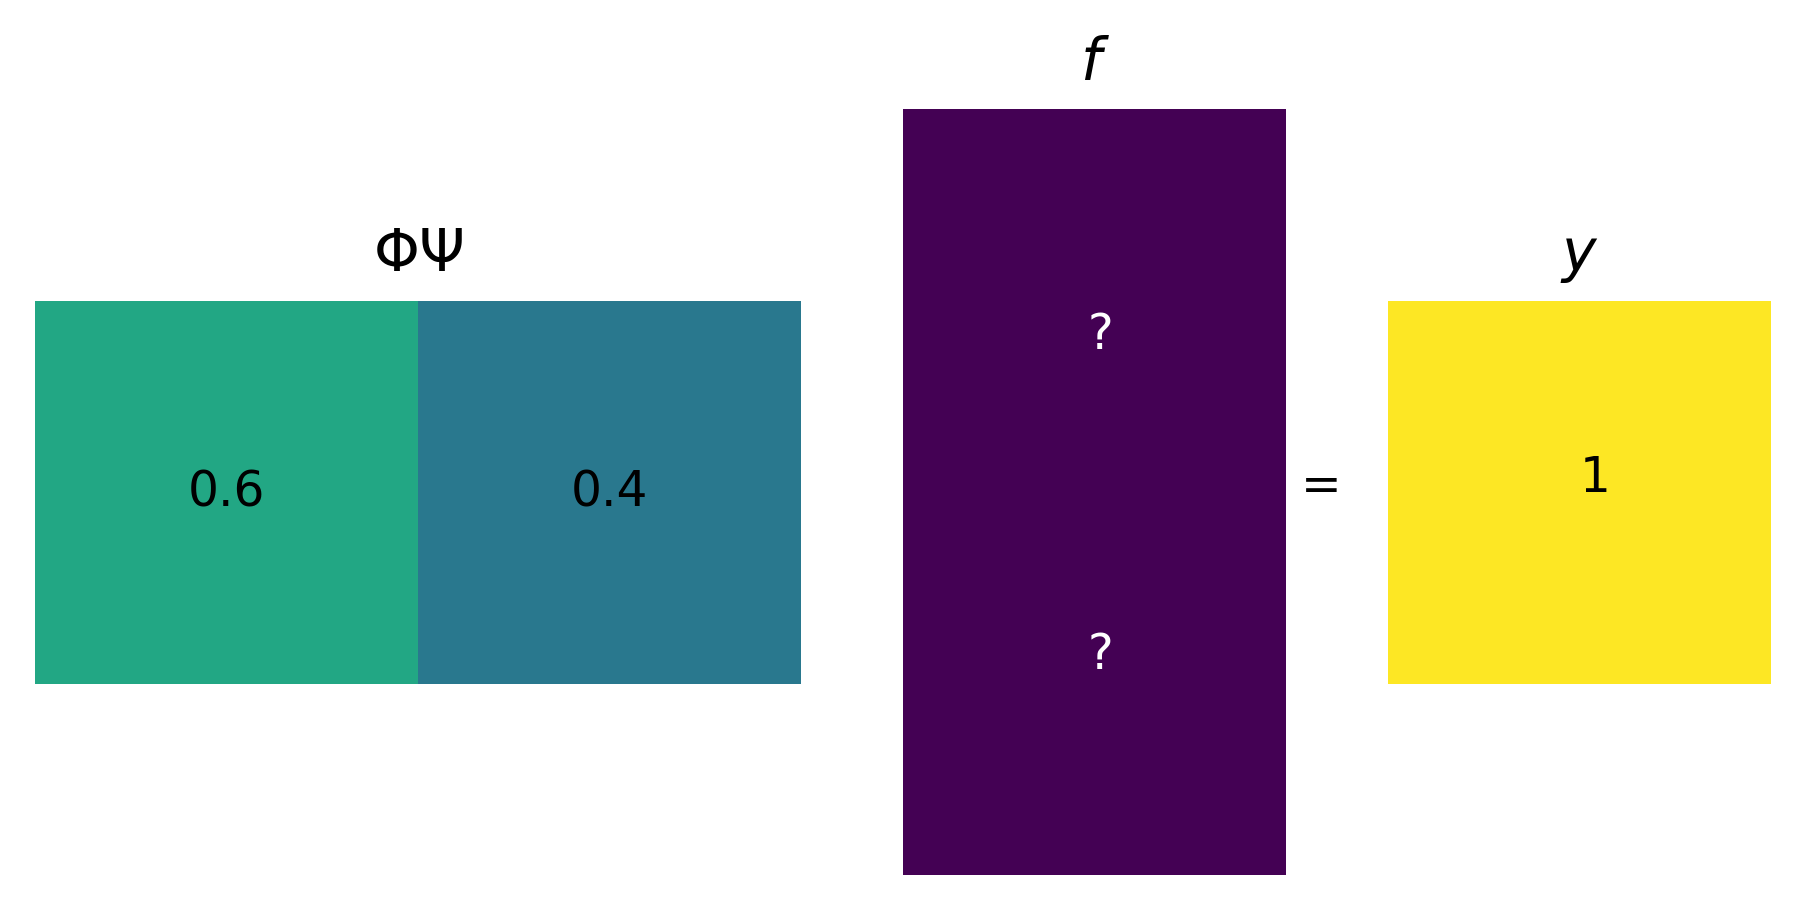

In [ ]:
f_small = torch.tensor([0,0])

import numpy as np

fig,ax = plt.subplots(1,3,dpi=350,gridspec_kw={'width_ratios': [2, 1, 1]})
ax[0].imshow(PhiPsi_small,vmax=1,vmin=0);ax[0].set_title(r'$\Phi\Psi$');ax[0].set_axis_off()
ax[1].imshow(f_small.unsqueeze(1),vmax=1,vmin=0);ax[1].set_title(r'$f$');ax[1].set_axis_off()
ax[2].imshow(y_small.unsqueeze(0),vmax=1,vmin=0);ax[2].set_title(r'$y$');ax[2].set_axis_off()

for (j,i),label in np.ndenumerate(PhiPsi_small):
    ax[0].text(i,j,label,ha='center',va='center')

ax[2].text(0,0,y_small.numpy()[0])

fig.text(0.69,0.49,'=')
fig.text(0.595,0.39,'?',color='w')
fig.text(0.595,0.58,'?',color='w')

#### Now lets look at possible values of $f_0$ and $f_1$ that will satisfy this equation.

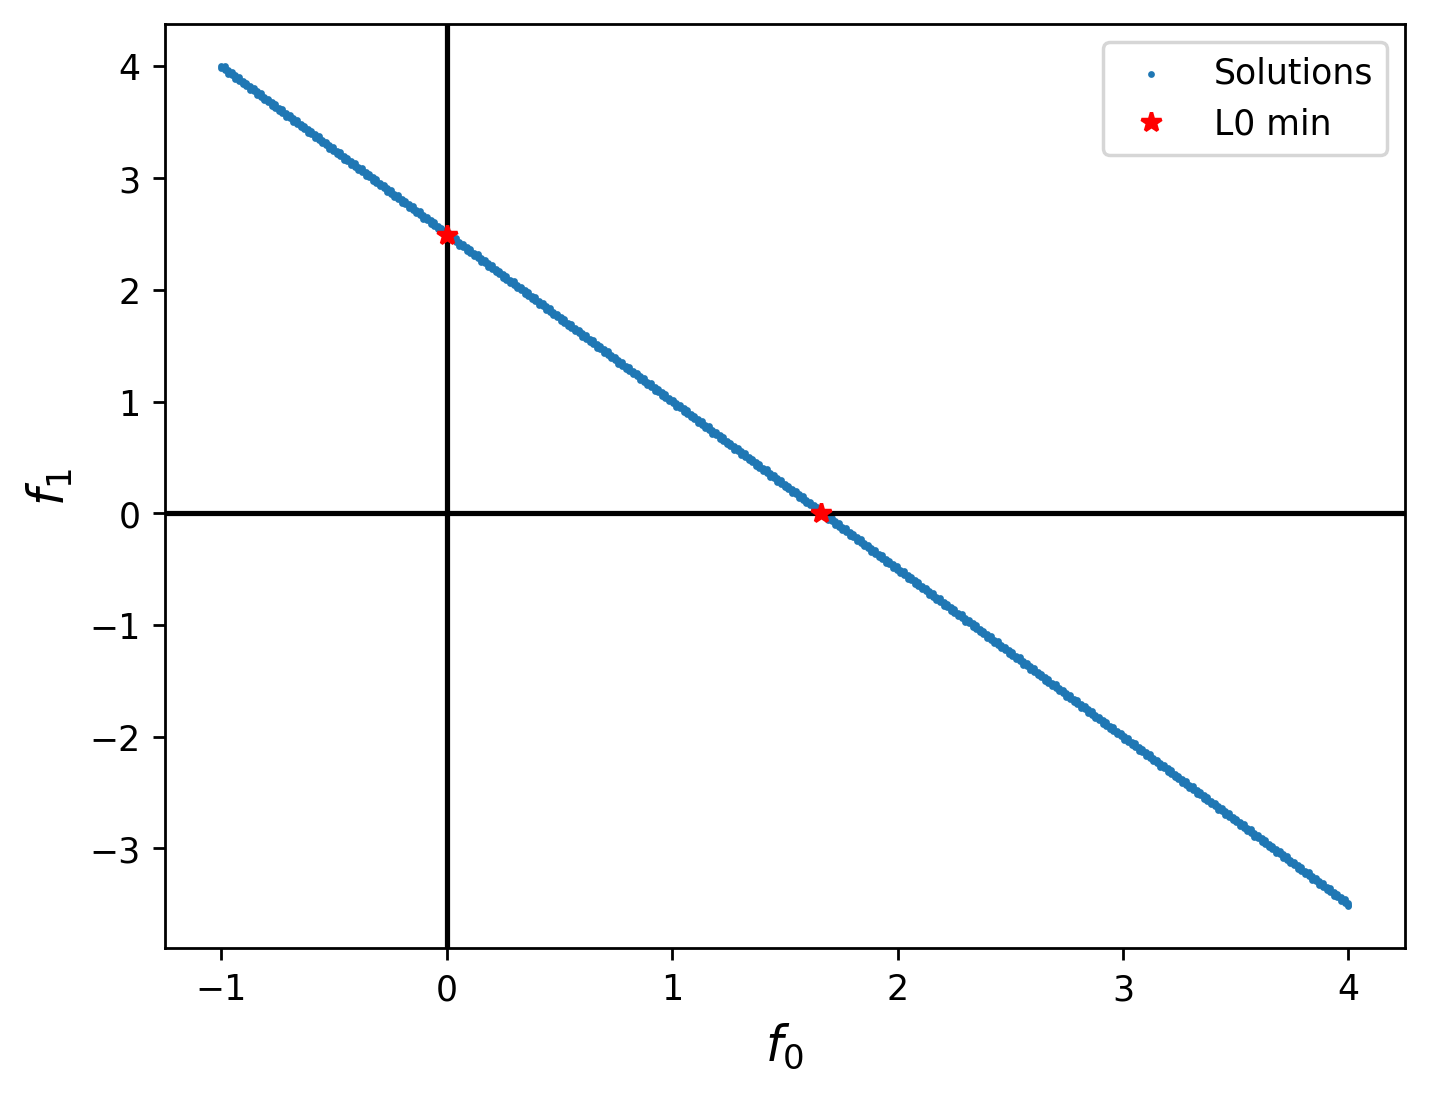

In [ ]:
threshold = 0.01

f0_range = torch.linspace(-4,4,500) #possible values of f0
f1_range = torch.linspace(-4,4,500)

save_indices = []

for i in f0_range:
    for j in f1_range:
        f_pred = torch.tensor([i,j])
        y_pred = PhiPsi_small@f_pred

        if torch.abs(y_pred - y_small) < threshold:
            save_indices.append([float(i),float(j)]) #if the loss is below a threshold, save the values.

save_indices = torch.tensor(save_indices)

plt.figure(dpi=250)
plt.scatter(save_indices[:,0],save_indices[:,1],s=0.9, label='Solutions');
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel(r'$f_{0}$', fontsize=14)
plt.ylabel(r'$f_{1}$', fontsize=14)

#### L0 ####

L0_indices_y = [0, save_indices[:,1][np.abs(save_indices[:,0]).argmin()]]
L0_indices_x = [save_indices[:,0][np.abs(save_indices[:,1]).argmin()], 0]
plt.plot(L0_indices_x, L0_indices_y,'r*',label='L0 min')

plt.legend()

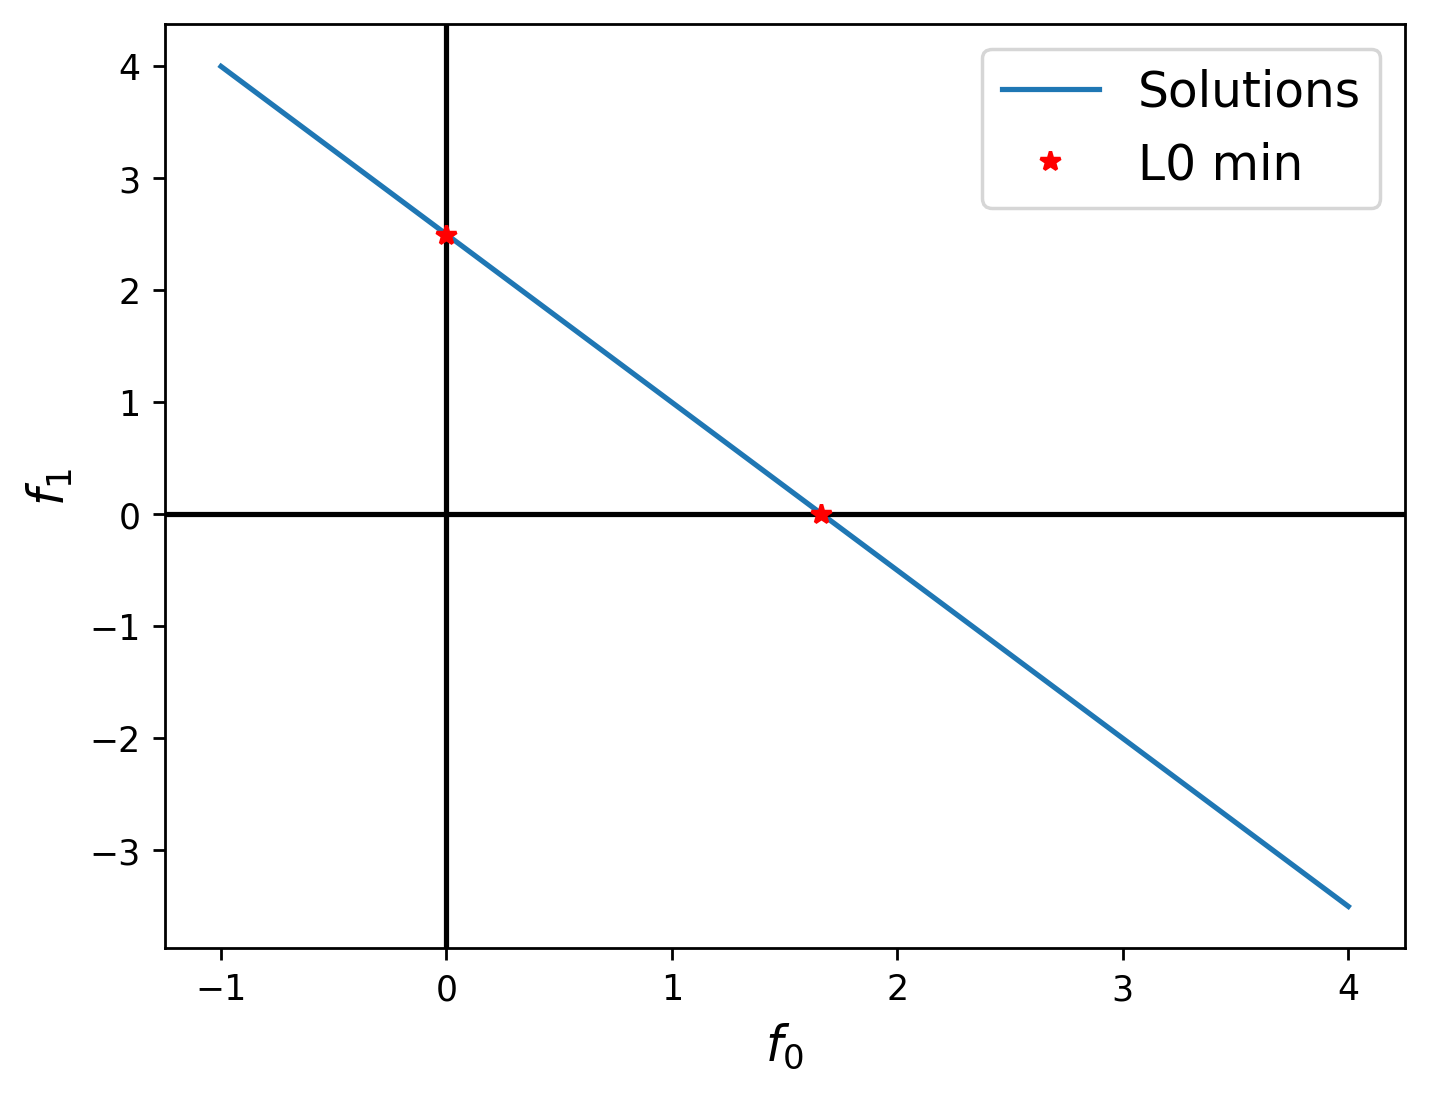

In [ ]:
x = np.linspace(-1,4,1000)
y = (1-.6*x)/.4

plt.figure(dpi=250)
plt.plot(x,y, label='Solutions');
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel(r'$f_{0}$', fontsize=14)
plt.ylabel(r'$f_{1}$', fontsize=14)

#### L0 ####

L0_indices_y = [0, save_indices[:,1][np.abs(save_indices[:,0]).argmin()]]
L0_indices_x = [save_indices[:,0][np.abs(save_indices[:,1]).argmin()], 0]
plt.plot(L0_indices_x, L0_indices_y,'r*',label='L0 min')

plt.legend(fontsize=14)

**In order to get a sparse solution, we desire the ones where the line of solutions passes through either the $f_{0}$ or $f_{1}$ axis (as this means a coefficient is 0).**

#### Lets now consider the solution that exists at the minimum value of either the $\ell_1$ or $\ell_2$ norm.

#### ***Starting with $\ell_2$, minimizing from left to right***

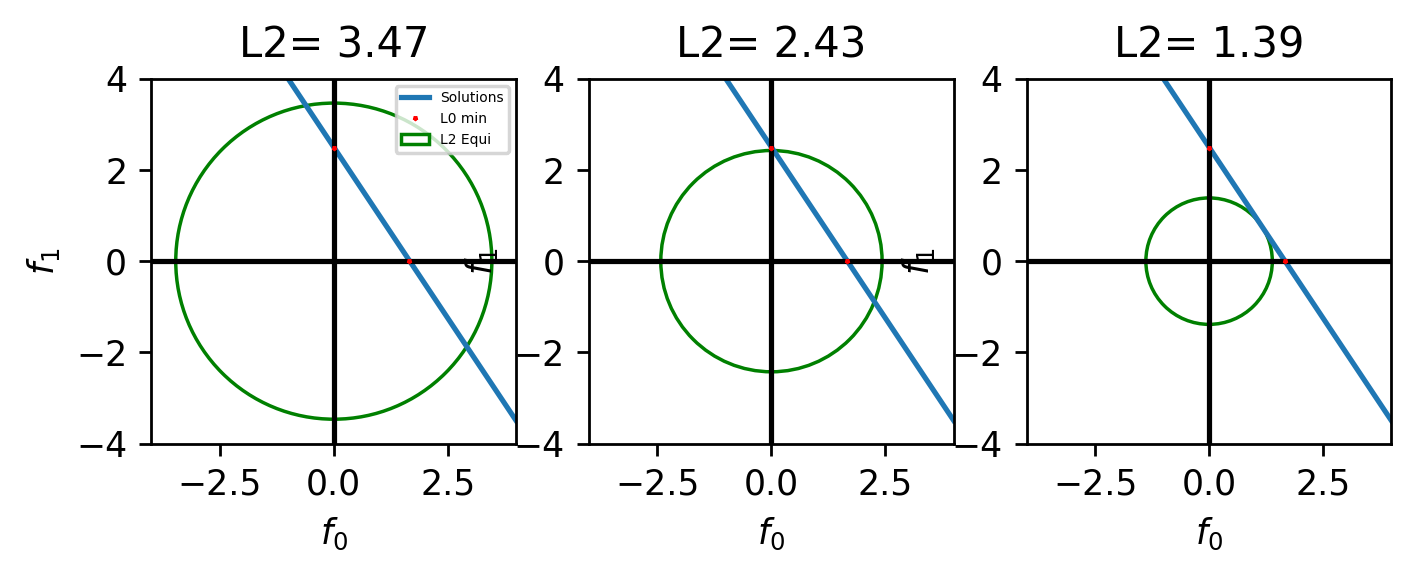

In [ ]:
f = torch.stack((torch.tensor(x),torch.tensor(y)),dim=1)

fig, ax = plt.subplots(1,3,dpi=250)

l2_norm_min = torch.norm(f,p=2,dim=1).min()


L2 = [l2_norm_min*2.5,l2_norm_min*1.75,l2_norm_min]
# fig.suptitle('L0')

for i in range(3):
    ax[i].set_aspect('equal')

    # ax[i].scatter(save_indices[:,0],save_indices[:,1],s=0.9, label='solutions');
    ax[i].plot(x,y, label='Solutions');
    ax[i].axhline(0, color='black')

    ax[i].axvline(0, color='black')
    ax[i].set_xlabel(r'$f_{0}$')
    ax[i].set_ylabel(r'$f_{1}$')
    ax[i].set_xlim([-4,4])
    ax[i].set_ylim([-4,4])
    ax[i].set_title(f'L2={np.round(L2[i],2):5.5g}')

    #### L0 ####

    L0_indices_y = [0, save_indices[:,1][np.abs(save_indices[:,0]).argmin()]]
    L0_indices_x = [save_indices[:,0][np.abs(save_indices[:,1]).argmin()], 0]
    ax[i].plot(L0_indices_x, L0_indices_y,'r*',label='L0 min',markersize=1)


    from matplotlib.patches import Rectangle, Circle


    ax[i].add_patch(Circle((0,0),L2[i],facecolor='None',edgecolor='g',label='L2 Equi'))


ax[0].legend(fontsize=4)

**So we see that if we take the solution with the minimal $\ell_2$ norm, this does not generally take us to a sparse solution. This is due to the circular shape of the $\ell_2$ norm.**

#### ***How about L1...***

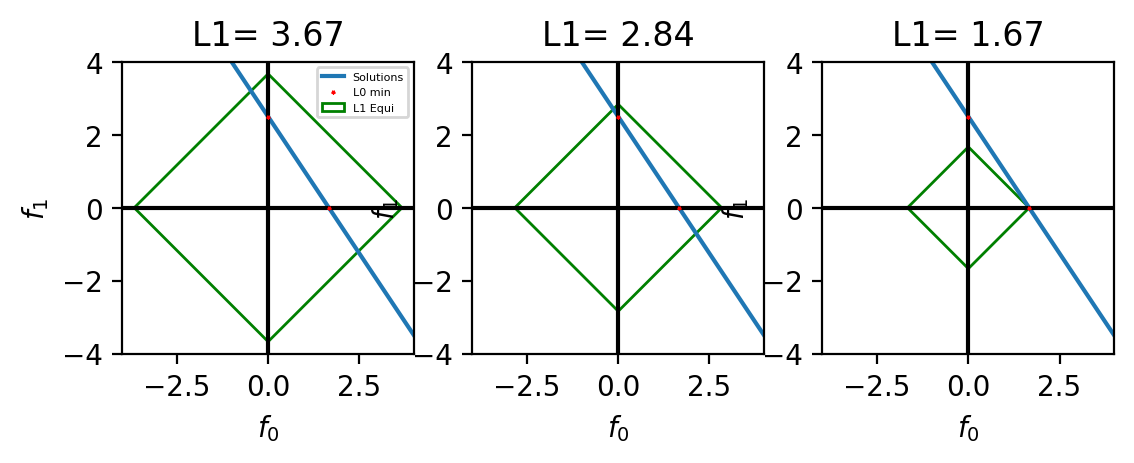

In [ ]:
fig, ax = plt.subplots(1,3,dpi=200)

l1_norm_min = torch.norm(f,p=1,dim=1).min()


L1 = [l1_norm_min*2.2,l1_norm_min*1.7,l1_norm_min]
# fig.suptitle('L0')

for i in range(3):
    ax[i].set_aspect('equal')

    ax[i].plot(x,y, label='Solutions');
    ax[i].axhline(0, color='black')
    ax[i].axvline(0, color='black')
    ax[i].set_xlabel(r'$f_{0}$')
    ax[i].set_ylabel(r'$f_{1}$')
    ax[i].set_xlim([-4,4])
    ax[i].set_ylim([-4,4])
    ax[i].set_title(f'L1={np.round(L1[i],2):5.5g}')

    #### L0 ####

    L0_indices_y = [0, save_indices[:,1][np.abs(save_indices[:,0]).argmin()]]
    L0_indices_x = [save_indices[:,0][np.abs(save_indices[:,1]).argmin()], 0]
    ax[i].plot(L0_indices_x, L0_indices_y,'r*',label='L0 min',markersize=1)


    from matplotlib.patches import Rectangle, Circle


    ax[i].add_patch(Rectangle((0,-L1[i]),np.sqrt(2)*L1[i],np.sqrt(2)*L1[i],angle=45,facecolor='None',edgecolor='g',label='L1 Equi'))


ax[0].legend(fontsize=4)

#### **We see that minimizing $\ell_1$ takes us to one of the $\ell_0$ minimiums!**
#### More specifically, it will always hit the $\ell_0$ minimum if the relationship is linear, due to the square shape of its contour, with the vertices on the feature axis.